<div style="text-align: right">Update date: Mar 3, 2024</div><br>


# Forecasting retail<br>
## Data preparation<br>

### Objetive<br>
Prepare the data to develop machine learning models on a database that has 3 years of history to predict sales for the next 8 days at the store-product level of a large distributor in the food sector.<br><br>

### The general outline of this notebook is as follows:<br>

    1. Imports and adjustments
    2. Load data
    3. Reserve the validation dataset
    4. Data quality
    5. Exploratory data analysis
    6. Transform variables
    7. Preselect variables
    8. Save training dataset
    
    
<br>

### Main work tools<br>


|Package|                           Version|
|:---------------------------------|--------:|
|cloudpickle                       |3.0.0|
|janitor                           |0.26.0|
|matplotlib                        |3.8.0|
|numpy                             | 1.26.3|
|notebook                          |6.5.4|
|pandas                            | 2.1.4|
|python                            |3.11.7|
|sklearn                           |1.2.2|
|sqlalchemy                        |2.0.25|
|xgboost                           |1.7.3|

### Imports and adjustments

In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sa
from janitor import clean_names
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import mutual_info_regression

%config IPCompleter.greedy = True

### Load data

In [3]:
connection_db = sa.create_engine('sqlite:///../data/original/hipermercado.db')
list_tables = sa.inspect(connection_db).get_table_names()
list_tables

['calendar', 'sales', 'sell_prices']

In [4]:
calendar = pd.read_sql('calendar', connection_db)
sales = pd.read_sql('sales', connection_db)
sell_prices = pd.read_sql('sell_prices', connection_db)
print(f'{calendar.shape=}')
print(f'{sales.shape=}')
print(f'{sell_prices.shape=}')

calendar.shape=(1095, 12)
sales.shape=(20, 1102)
sell_prices.shape=(3129, 5)


First look

In [5]:
calendar.head()

index        date  wm_yr_wk    weekday  wday  month  year      d  \
0      0  2013-01-01     11249    Tuesday     4      1  2013  d_704   
1      1  2013-01-02     11249  Wednesday     5      1  2013  d_705   
2      2  2013-01-03     11249   Thursday     6      1  2013  d_706   
3      3  2013-01-04     11249     Friday     7      1  2013  d_707   
4      4  2013-01-05     11250   Saturday     1      1  2013  d_708   

  event_name_1 event_type_1 event_name_2 event_type_2  
0      NewYear     National         None         None  
1         None         None         None         None  
2         None         None         None         None  
3         None         None         None         None  
4         None         None         None         None

In [6]:
sales.head()

index                           id      item_id  dept_id cat_id store_id  \
0   8412  FOODS_3_090_CA_3_validation  FOODS_3_090  FOODS_3  FOODS     CA_3   
1   8442  FOODS_3_120_CA_3_validation  FOODS_3_120  FOODS_3  FOODS     CA_3   
2   8524  FOODS_3_202_CA_3_validation  FOODS_3_202  FOODS_3  FOODS     CA_3   
3   8574  FOODS_3_252_CA_3_validation  FOODS_3_252  FOODS_3  FOODS     CA_3   
4   8610  FOODS_3_288_CA_3_validation  FOODS_3_288  FOODS_3  FOODS     CA_3   

  state_id  d_704  d_705  d_706  ...  d_1789  d_1790  d_1791  d_1792  d_1793  \
0       CA      0    224    241  ...       5       2       0       0       6   
1       CA      0      0      0  ...      54      63      44       0      65   
2       CA     20     23     23  ...      43      40      39       0      29   
3       CA     34     27     40  ...      31      43      32       0      52   
4       CA      0      0      0  ...      29      45      28       0      46   

   d_1794  d_1795  d_1796  d_1797  d_1798  
0       0       6       0       0       0  
1      90     104      73      76      97  
2      33      27      13      26      47  
3      37      32      29      34      27  
4      36      40      31      46      36  

[5 rows x 1102 columns]

In [7]:
sell_prices.head()

index store_id      item_id  wm_yr_wk  sell_price
0  1862524     CA_3  FOODS_3_090     11249        1.25
1  1862525     CA_3  FOODS_3_090     11250        1.25
2  1862526     CA_3  FOODS_3_090     11251        1.25
3  1862527     CA_3  FOODS_3_090     11252        1.25
4  1862528     CA_3  FOODS_3_090     11301        1.38

Review table relationships

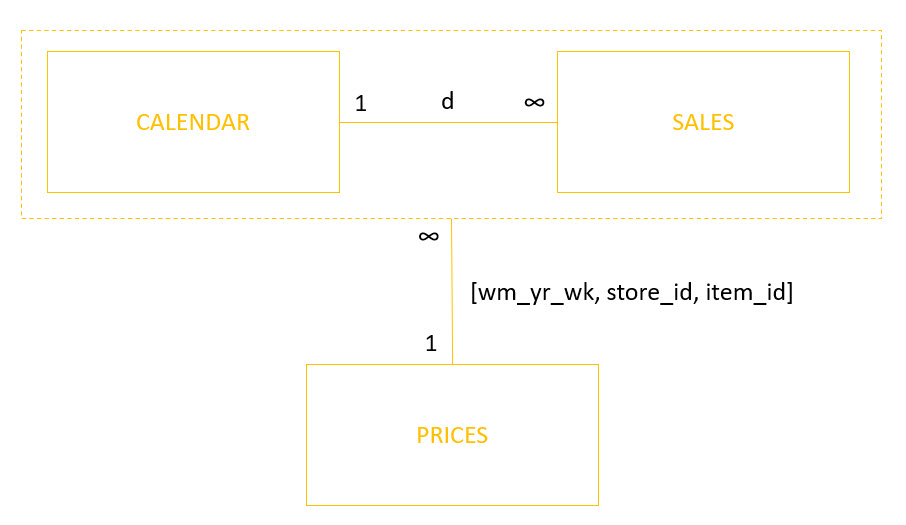

In [8]:
from IPython import display

display.Image('../media/retail_relations_tables.jpg')

**Generate analytical table**

Change sales table structure

In [8]:
sales = sales.melt(
    id_vars=['index', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d',
    value_name='sales'
)
print(f'{sales.shape=}')
sales.head()

sales.shape=(21900, 9)


index                           id      item_id  dept_id cat_id store_id  \
0   8412  FOODS_3_090_CA_3_validation  FOODS_3_090  FOODS_3  FOODS     CA_3   
1   8442  FOODS_3_120_CA_3_validation  FOODS_3_120  FOODS_3  FOODS     CA_3   
2   8524  FOODS_3_202_CA_3_validation  FOODS_3_202  FOODS_3  FOODS     CA_3   
3   8574  FOODS_3_252_CA_3_validation  FOODS_3_252  FOODS_3  FOODS     CA_3   
4   8610  FOODS_3_288_CA_3_validation  FOODS_3_288  FOODS_3  FOODS     CA_3   

  state_id      d  sales  
0       CA  d_704      0  
1       CA  d_704      0  
2       CA  d_704     20  
3       CA  d_704     34  
4       CA  d_704      0

Remove unnecessary columns from tables: sales, calendar, sell_prices

In [9]:
sales.drop(columns=['index', 'id'], inplace=True)
calendar.drop(columns=['index'], inplace=True)
sell_prices.drop(columns=['index'], inplace=True)

Add calendar to the sales table

In [10]:
df = sales.merge(calendar, how='left', on='d')
print(f'{df.shape=}')
df.head()

df.shape=(21900, 17)


item_id  dept_id cat_id store_id state_id      d  sales        date  \
0  FOODS_3_090  FOODS_3  FOODS     CA_3       CA  d_704      0  2013-01-01   
1  FOODS_3_120  FOODS_3  FOODS     CA_3       CA  d_704      0  2013-01-01   
2  FOODS_3_202  FOODS_3  FOODS     CA_3       CA  d_704     20  2013-01-01   
3  FOODS_3_252  FOODS_3  FOODS     CA_3       CA  d_704     34  2013-01-01   
4  FOODS_3_288  FOODS_3  FOODS     CA_3       CA  d_704      0  2013-01-01   

   wm_yr_wk  weekday  wday  month  year event_name_1 event_type_1  \
0     11249  Tuesday     4      1  2013      NewYear     National   
1     11249  Tuesday     4      1  2013      NewYear     National   
2     11249  Tuesday     4      1  2013      NewYear     National   
3     11249  Tuesday     4      1  2013      NewYear     National   
4     11249  Tuesday     4      1  2013      NewYear     National   

  event_name_2 event_type_2  
0         None         None  
1         None         None  
2         None         None  
3         None         None  
4         None         None

Add sales price

In [11]:
df = df.merge(sell_prices, how='left', on=['wm_yr_wk', 'store_id', 'item_id'])
print(f'{df.shape=}')
df.head()

df.shape=(21900, 18)


item_id  dept_id cat_id store_id state_id      d  sales        date  \
0  FOODS_3_090  FOODS_3  FOODS     CA_3       CA  d_704      0  2013-01-01   
1  FOODS_3_120  FOODS_3  FOODS     CA_3       CA  d_704      0  2013-01-01   
2  FOODS_3_202  FOODS_3  FOODS     CA_3       CA  d_704     20  2013-01-01   
3  FOODS_3_252  FOODS_3  FOODS     CA_3       CA  d_704     34  2013-01-01   
4  FOODS_3_288  FOODS_3  FOODS     CA_3       CA  d_704      0  2013-01-01   

   wm_yr_wk  weekday  wday  month  year event_name_1 event_type_1  \
0     11249  Tuesday     4      1  2013      NewYear     National   
1     11249  Tuesday     4      1  2013      NewYear     National   
2     11249  Tuesday     4      1  2013      NewYear     National   
3     11249  Tuesday     4      1  2013      NewYear     National   
4     11249  Tuesday     4      1  2013      NewYear     National   

  event_name_2 event_type_2  sell_price  
0         None         None        1.25  
1         None         None        4.98  
2         None         None        4.28  
3         None         None        1.48  
4         None         None         NaN

Organize columns

In [12]:
column_order = [
    'date',
    'state_id',
    'store_id',
    'dept_id',
    'cat_id',
    'item_id',
    'wm_yr_wk',
    'd',
    'sales',
    'sell_price',
    'year',
    'month',
    'wday',
    'weekday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2'
]
df = df[column_order].set_index('date')
print(f'{df.shape=}')
df.head()

df.shape=(21900, 17)


state_id store_id  dept_id cat_id      item_id  wm_yr_wk      d  \
date                                                                         
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_090     11249  d_704   
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_120     11249  d_704   
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_202     11249  d_704   
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_252     11249  d_704   
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_288     11249  d_704   

            sales  sell_price  year  month  wday  weekday event_name_1  \
date                                                                     
2013-01-01      0        1.25  2013      1     4  Tuesday      NewYear   
2013-01-01      0        4.98  2013      1     4  Tuesday      NewYear   
2013-01-01     20        4.28  2013      1     4  Tuesday      NewYear   
2013-01-01     34        1.48  2013      1     4  Tuesday      NewYear   
2013-01-01      0         NaN  2013      1     4  Tuesday      NewYear   

           event_type_1 event_name_2 event_type_2  
date                                               
2013-01-01     National         None         None  
2013-01-01     National         None         None  
2013-01-01     National         None         None  
2013-01-01     National         None         None  
2013-01-01     National         None         None

### Reserve the validation dataset

In [13]:
validation = df['2015-12-01':'2015-12-31']
work = df[:'2015-11-31']

In [14]:
validation.to_csv('../data/validation/validation.csv')

Save the working dataset

In [15]:
work.to_csv('../data/work.csv')

### Data quality

In [9]:
df = pd.read_csv('../data/work.csv', parse_dates=['date'], index_col='date')
print(f'{df.shape=}')
df.head()

df.shape=(21280, 17)


state_id store_id  dept_id cat_id      item_id  wm_yr_wk      d  \
date                                                                         
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_090     11249  d_704   
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_120     11249  d_704   
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_202     11249  d_704   
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_252     11249  d_704   
2013-01-01       CA     CA_3  FOODS_3  FOODS  FOODS_3_288     11249  d_704   

            sales  sell_price  year  month  wday  weekday event_name_1  \
date                                                                     
2013-01-01      0        1.25  2013      1     4  Tuesday      NewYear   
2013-01-01      0        4.98  2013      1     4  Tuesday      NewYear   
2013-01-01     20        4.28  2013      1     4  Tuesday      NewYear   
2013-01-01     34        1.48  2013      1     4  Tuesday      NewYear   
2013-01-01      0         NaN  2013      1     4  Tuesday      NewYear   

           event_type_1 event_name_2 event_type_2  
date                                               
2013-01-01     National          NaN          NaN  
2013-01-01     National          NaN          NaN  
2013-01-01     National          NaN          NaN  
2013-01-01     National          NaN          NaN  
2013-01-01     National          NaN          NaN

Overview

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21280 entries, 2013-01-01 to 2015-11-30
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   state_id      21280 non-null  object 
 1   store_id      21280 non-null  object 
 2   dept_id       21280 non-null  object 
 3   cat_id        21280 non-null  object 
 4   item_id       21280 non-null  object 
 5   wm_yr_wk      21280 non-null  int64  
 6   d             21280 non-null  object 
 7   sales         21280 non-null  int64  
 8   sell_price    21209 non-null  float64
 9   year          21280 non-null  int64  
 10  month         21280 non-null  int64  
 11  wday          21280 non-null  int64  
 12  weekday       21280 non-null  object 
 13  event_name_1  1700 non-null   object 
 14  event_type_1  1700 non-null   object 
 15  event_name_2  60 non-null     object 
 16  event_type_2  60 non-null     object 
dtypes: float64(1), int64(5), object(11)
memory usage: 2.

Conclusions:

year, month, wday: Change the data type to categorical to optimize memory usage and improve performance on some operations.

####  Data types

In [13]:
df = df.astype({
    'year': 'category',
    'month': 'category',
    'wday': 'category'
})
df.dtypes

state_id          object
store_id          object
dept_id           object
cat_id            object
item_id           object
wm_yr_wk           int64
d                 object
sales              int64
sell_price       float64
year            category
month           category
wday            category
weekday           object
event_name_1      object
event_type_1      object
event_name_2      object
event_type_2      object
dtype: object

#### Unique values

In [15]:
df.nunique().sort_values()

state_id           1
cat_id             1
dept_id            1
event_type_2       2
store_id           2
event_name_2       3
year               3
event_type_1       4
wday               7
weekday            7
item_id           10
month             12
sell_price        23
event_name_1      30
wm_yr_wk         153
sales            301
d               1064
dtype: int64

Delete variables with unique values

In [16]:
df.drop(columns=['state_id', 'cat_id', 'dept_id'], inplace=True)

#### Duplicates

In [18]:
df.duplicated().sum()

0

#### Separate numerical and categorical variables

Categorical

In [21]:
cat = df.select_dtypes(exclude='number').copy()

Numeric

In [22]:
num = df.select_dtypes(include='number').copy()

#### Management of categorical variables

##### Nulls

In [25]:
cat.isnull().sum().sort_values(ascending=False)

event_name_2    21220
event_type_2    21220
event_name_1    19580
event_type_1    19580
store_id            0
item_id             0
d                   0
year                0
month               0
wday                0
weekday             0
dtype: int64

In [26]:
cat.event_name_1.value_counts(dropna=False)

event_name_1
NaN                    19580
NewYear                   60
Mother's day              60
Thanksgiving              60
VeteransDay               60
Halloween                 60
EidAlAdha                 60
ColumbusDay               60
LaborDay                  60
Eid al-Fitr               60
Ramadan starts            60
IndependenceDay           60
NBAFinalsEnd              60
NBAFinalsStart            60
MemorialDay               60
Pesach End                60
Easter                    60
StPatricksDay             60
Purim End                 60
LentWeek2                 60
PresidentsDay             60
ValentinesDay             60
LentStart                 60
SuperBowl                 60
MartinLutherKingDay       60
OrthodoxChristmas         60
OrthodoxEaster            40
Father's day              40
Chanukah End              40
Christmas                 40
Cinco De Mayo             40
Name: count, dtype: int64

In [27]:
cat.event_name_2.value_counts(dropna=False)

event_name_2
NaN               21220
Cinco De Mayo        20
OrthodoxEaster       20
Father's day         20
Name: count, dtype: int64

In [28]:
cat.event_type_1.value_counts(dropna=False)

event_type_1
NaN          19580
National       580
Religious      560
Cultural       380
Sporting       180
Name: count, dtype: int64

In [29]:
cat.event_type_2.value_counts(dropna=False)

event_type_2
NaN          21220
Cultural        40
Religious       20
Name: count, dtype: int64

In [30]:
pd.crosstab(index=cat.event_name_1, columns=cat.event_name_2)

event_name_2    Cinco De Mayo  Father's day  OrthodoxEaster
event_name_1                                               
Easter                      0             0              20
NBAFinalsEnd                0            20               0
OrthodoxEaster             20             0               0

Conclusions:
* event_name_1 has events that are included in event_name_2
* but when you cross them they don't match
* Delete event_name_2 and event_type_2
* Regarding the null values of event_name_1 and event_type_1, it seems clear that they are days without an event, so an imputation will be made.


Delete variables event_name_2 and event_type_2

In [31]:
cat.drop(columns=['event_name_2', 'event_type_2'], inplace=True)

##### Impute by a value

In [32]:
vars_impute = ['event_name_1', 'event_type_1']
value = 'No_event'
cat[vars_impute] = cat[vars_impute].fillna(value)

Validate changes

In [35]:
cat.isnull().sum()

store_id        0
item_id         0
d               0
year            0
month           0
wday            0
weekday         0
event_name_1    0
event_type_1    0
dtype: int64

##### Outlier values

Uncommon categories

In [36]:
for variable in cat:
    print(variable + '\n')
    print(cat[variable].value_counts(dropna=False))
    print('\n\n')

store_id

store_id
CA_3    10640
CA_4    10640
Name: count, dtype: int64



item_id

item_id
FOODS_3_090    2128
FOODS_3_120    2128
FOODS_3_202    2128
FOODS_3_252    2128
FOODS_3_288    2128
FOODS_3_329    2128
FOODS_3_555    2128
FOODS_3_586    2128
FOODS_3_587    2128
FOODS_3_714    2128
Name: count, dtype: int64



d

d
d_704     20
d_1418    20
d_1404    20
d_1405    20
d_1406    20
          ..
d_1064    20
d_1065    20
d_1066    20
d_1067    20
d_1767    20
Name: count, Length: 1064, dtype: int64



year

year
2013    7300
2014    7300
2015    6680
Name: count, dtype: int64



month

month
1     1860
3     1860
5     1860
7     1860
8     1860
10    1860
4     1800
6     1800
9     1800
11    1800
2     1680
12    1240
Name: count, dtype: int64



wday

wday
1    3040
2    3040
3    3040
4    3040
5    3040
6    3040
7    3040
Name: count, dtype: int64



weekday

weekday
Tuesday      3040
Wednesday    3040
Thursday     3040
Friday       3040
Saturday     3040
Sunday       3040

Conclusions:
* There are no variables with infrequent categories
* There are months with fewer records (months with less than 31 days)
* 2015 has fewer records (probably validation records)

In [41]:
df.groupby('year', observed=False).d.nunique()

year
2013    365
2014    365
2015    334
Name: d, dtype: int64

In [42]:
pd.date_range(start='2015-01-01', end='2015-12-31').difference(df.loc['2015'].index)

DatetimeIndex(['2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
               '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08',
               '2015-12-09', '2015-12-10', '2015-12-11', '2015-12-12',
               '2015-12-13', '2015-12-14', '2015-12-15', '2015-12-16',
               '2015-12-17', '2015-12-18', '2015-12-19', '2015-12-20',
               '2015-12-21', '2015-12-22', '2015-12-23', '2015-12-24',
               '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
               '2015-12-29', '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', freq=None)

The difference is due to the separation of the dataset to build the validation dataset.

#### Management of numerical variables

##### Statisticians

In [44]:
num.describe().T

count          mean        std      min      25%       50%  \
wm_yr_wk    21280.0  11415.022556  82.874752  11249.0  11335.0  11420.00   
sales       21280.0     28.874577  38.988147      0.0      6.0     18.00   
sell_price  21209.0      2.397254   1.237024      1.0      1.5      1.58   

                 75%       max  
wm_yr_wk    11506.00  11544.00  
sales          37.00    763.00  
sell_price      2.98      4.98

##### Nulls

In [46]:
num.isnull().sum().sort_values(ascending=False)

sell_price    71
wm_yr_wk       0
sales          0
dtype: int64

Analyze sell_price, since it is a relevant variable

In [52]:
# By product
(df.groupby('item_id')
 .apply(lambda x: x.sell_price.isnull().sum())
 .sort_values(ascending=False)
)

item_id
FOODS_3_288    71
FOODS_3_090     0
FOODS_3_120     0
FOODS_3_202     0
FOODS_3_252     0
FOODS_3_329     0
FOODS_3_555     0
FOODS_3_586     0
FOODS_3_587     0
FOODS_3_714     0
dtype: int64

In [56]:
# By sales
(df.groupby('sales')
 .apply(lambda x: x.sell_price.isnull().sum())
 .sort_values(ascending=False)
)

sales
0      71
210     0
207     0
206     0
205     0
       ..
100     0
99      0
98      0
97      0
763     0
Length: 301, dtype: int64

Conclusions:
Null values of the sell_price variable are located on a product, on days with zero sales.

Impute the null values of the sell_price variable by the most frequent value of each product (the fashion).

In [75]:
num = pd.concat([num, cat.item_id], axis=1)
print(f'{num.shape}')
num.head()

(21280, 4)


wm_yr_wk  sales  sell_price      item_id
date                                                
2013-01-01     11249      0        1.25  FOODS_3_090
2013-01-01     11249      0        4.98  FOODS_3_120
2013-01-01     11249     20        4.28  FOODS_3_202
2013-01-01     11249     34        1.48  FOODS_3_252
2013-01-01     11249      0         NaN  FOODS_3_288

In [80]:
def impute_mode(df, column):
    mode_value = df[column].mode()[0]
    df[column] = df[column].fillna(mode_value)
    return df

num = (num.groupby('item_id', group_keys=False)
       .apply(lambda x: impute_mode(x, 'sell_price')))

Verify imputation

In [81]:
num.groupby('item_id').sell_price.value_counts()

item_id      sell_price
FOODS_3_090  1.48           658
             1.38           546
             1.44           504
             1.00           280
             1.50            90
             1.25            50
FOODS_3_120  4.98          2128
FOODS_3_202  4.58           727
             4.38           525
             4.28           386
             3.98           350
             3.00           105
             3.33            21
             4.48             7
             3.25             7
FOODS_3_252  1.58          1182
             1.48           946
FOODS_3_288  1.50          2100
             1.25            21
             1.18             7
FOODS_3_329  2.98          2079
             2.74            42
             1.98             7
FOODS_3_555  1.58          1149
             1.68           979
FOODS_3_586  1.58          1149
             1.68           979
FOODS_3_587  2.48          1644
             2.68           421
             1.98            63
FOODS_3_714  1.5

Delete variable item_id from dataset num

In [82]:
num.drop(columns='item_id', inplace=True)
print(f'{num.shape=}')
num.head()

num.shape=(21280, 3)


wm_yr_wk  sales  sell_price
date                                   
2013-01-01     11249      0        1.25
2013-01-01     11249     33        1.25
2013-01-01     11249      0        4.98
2013-01-01     11249      0        4.98
2013-01-01     11249     20        4.28

##### Outliers values

Build function to find outliers of a variable

In [85]:
def outliers_std(variable, num_std=4):
    """Get the indexes of the outlier values of a variable based
     in the number of standard deviations"""
    not_null_variable = variable.dropna()
    
    media = np.mean(not_null_variable)
    std = np.std(not_null_variable)
    umbral = std * num_std
    lim_inf = media - umbral
    lim_sup = media + umbral
    outliers_indexes = variable[(variable < lim_inf) | (variable > lim_sup)].index
    
    return outliers_indexes

def count_outliers(df, variable, num_std=4):
    outliers = outliers_std(df[variable], num_std)
    return df.loc[outliers, variable].value_counts()


In [87]:
vars_outliers = ['sales', 'sell_price']
for variable in vars_outliers:
    print('\n' + variable + ':\n')
    print(count_outliers(num, variable, 4))


sales:

sales
0      518
1      103
5      100
10      95
7       92
      ... 
340      1
239      1
250      1
469      1
323      1
Name: count, Length: 247, dtype: int64

sell_price:

Series([], Name: count, dtype: int64)


<Axes: xlabel='sales'>

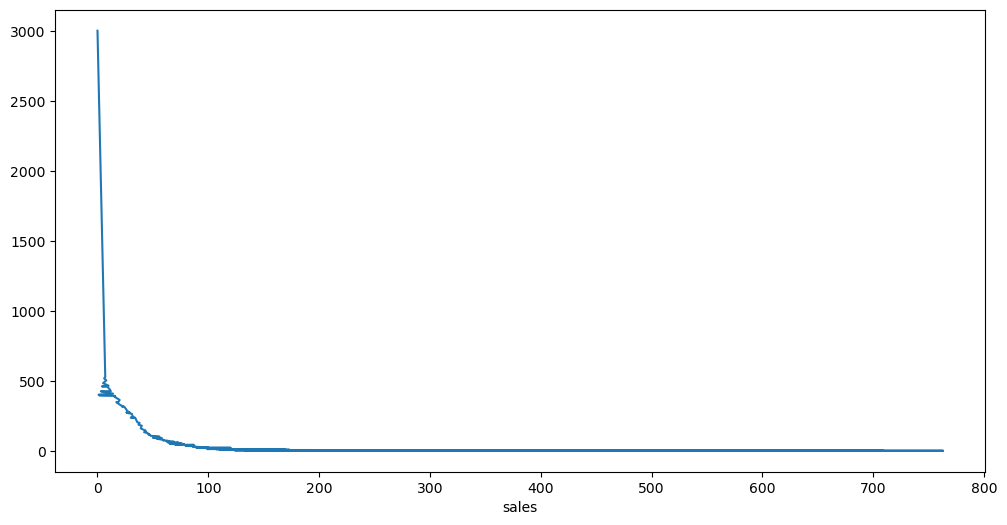

In [88]:
num.sales.value_counts().plot(figsize=(12, 6))

It is a long tail case, since there are few cases with high sales

#### Save datasets

In [94]:
df.to_pickle('../data/work_quality.pickle')
num.to_pickle('../data/num_quality.pickle')
cat.to_pickle('../data/cat_quality.pickle')

### Exploratory data analysis

##### Load data

In [11]:
cat = pd.read_pickle('../data/cat_quality.pickle')
num = pd.read_pickle('../data/num_quality.pickle')

#### EDA Categorical

##### Statistic analysis

In [12]:
cat.columns.to_list()

['store_id',
 'item_id',
 'd',
 'year',
 'month',
 'wday',
 'weekday',
 'event_name_1',
 'event_type_1']

Exclude the variable "d" from the analysis

In [13]:
include = cat.columns.to_list()
del include[2]

In [14]:
def get_cat_frequency(df_cat):
    df_cat = df_cat.astype(str)
    result = (
        df_cat.apply(lambda x: x.value_counts(normalize=True))
        .T
        .stack()
        .reset_index()
        .rename(columns={"level_0": "Variable", "level_1": "Value", 0: "Frequency"})
        .sort_values(by=["Variable", "Frequency"])
    )
    return result

In [15]:
pd.set_option('display.max_rows', None)
get_cat_frequency(cat[include])

Variable                Value  Frequency
41  event_name_1         Chanukah End   0.001880
42  event_name_1            Christmas   0.001880
43  event_name_1        Cinco De Mayo   0.001880
48  event_name_1         Father's day   0.001880
62  event_name_1       OrthodoxEaster   0.001880
44  event_name_1          ColumbusDay   0.002820
45  event_name_1               Easter   0.002820
46  event_name_1          Eid al-Fitr   0.002820
47  event_name_1            EidAlAdha   0.002820
49  event_name_1            Halloween   0.002820
50  event_name_1      IndependenceDay   0.002820
51  event_name_1             LaborDay   0.002820
52  event_name_1            LentStart   0.002820
53  event_name_1            LentWeek2   0.002820
54  event_name_1  MartinLutherKingDay   0.002820
55  event_name_1          MemorialDay   0.002820
56  event_name_1         Mother's day   0.002820
57  event_name_1         NBAFinalsEnd   0.002820
58  event_name_1       NBAFinalsStart   0.002820
59  event_name_1              NewYear   0.002820
61  event_name_1    OrthodoxChristmas   0.002820
63  event_name_1           Pesach End   0.002820
64  event_name_1        PresidentsDay   0.002820
65  event_name_1            Purim End   0.002820
66  event_name_1       Ramadan starts   0.002820
67  event_name_1        StPatricksDay   0.002820
68  event_name_1            SuperBowl   0.002820
69  event_name_1         Thanksgiving   0.002820
70  event_name_1        ValentinesDay   0.002820
71  event_name_1          VeteransDay   0.002820
60  event_name_1             No_event   0.920113
76  event_type_1             Sporting   0.008459
72  event_type_1             Cultural   0.017857
75  event_type_1            Religious   0.026316
73  event_type_1             National   0.027256
74  event_type_1             No_event   0.920113
2        item_id          FOODS_3_090   0.100000
3        item_id          FOODS_3_120   0.100000
4        item_id          FOODS_3_202   0.100000
5        item_id          FOODS_3_252   0.100000
6        item_id          FOODS_3_288   0.100000
7        item_id          FOODS_3_329   0.100000
8        item_id          FOODS_3_555   0.100000
9        item_id          FOODS_3_586   0.100000
10       item_id          FOODS_3_587   0.100000
11       item_id          FOODS_3_714   0.100000
18         month                   12   0.058271
19         month                    2   0.078947
17         month                   11   0.084586
21         month                    4   0.084586
23         month                    6   0.084586
26         month                    9   0.084586
15         month                    1   0.087406
16         month                   10   0.087406
20         month                    3   0.087406
22         month                    5   0.087406
24         month                    7   0.087406
25         month                    8   0.087406
0       store_id                 CA_3   0.500000
1       store_id                 CA_4   0.500000
27          wday                    1   0.142857
28          wday                    2   0.142857
29          wday                    3   0.142857
30          wday                    4   0.142857
31          wday                    5   0.142857
32          wday                    6   0.142857
33          wday                    7   0.142857
34       weekday               Friday   0.142857
35       weekday               Monday   0.142857
36       weekday             Saturday   0.142857
37       weekday               Sunday   0.142857
38       weekday             Thursday   0.142857
39       weekday              Tuesday   0.142857
40       weekday            Wednesday   0.142857
14          year                 2015   0.313910
12          year                 2013   0.343045
13          year                 2014   0.343045

In [16]:
pd.set_option('display.max_rows', 10)

##### Graphic analysis

In [17]:
def graph_eda_categorical(cat):
    
    from math import ceil
    rows = ceil(cat.shape[1] / 2)

    #Graph each variable
    f, ax = plt.subplots(nrows=rows, ncols=2, figsize=(16, rows * 6))
    ax = ax.flat 
    for index, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax=ax[index])
        ax[index].set_title(variable, fontsize=12, fontweight="bold")
        ax[index].tick_params(labelsize=12)

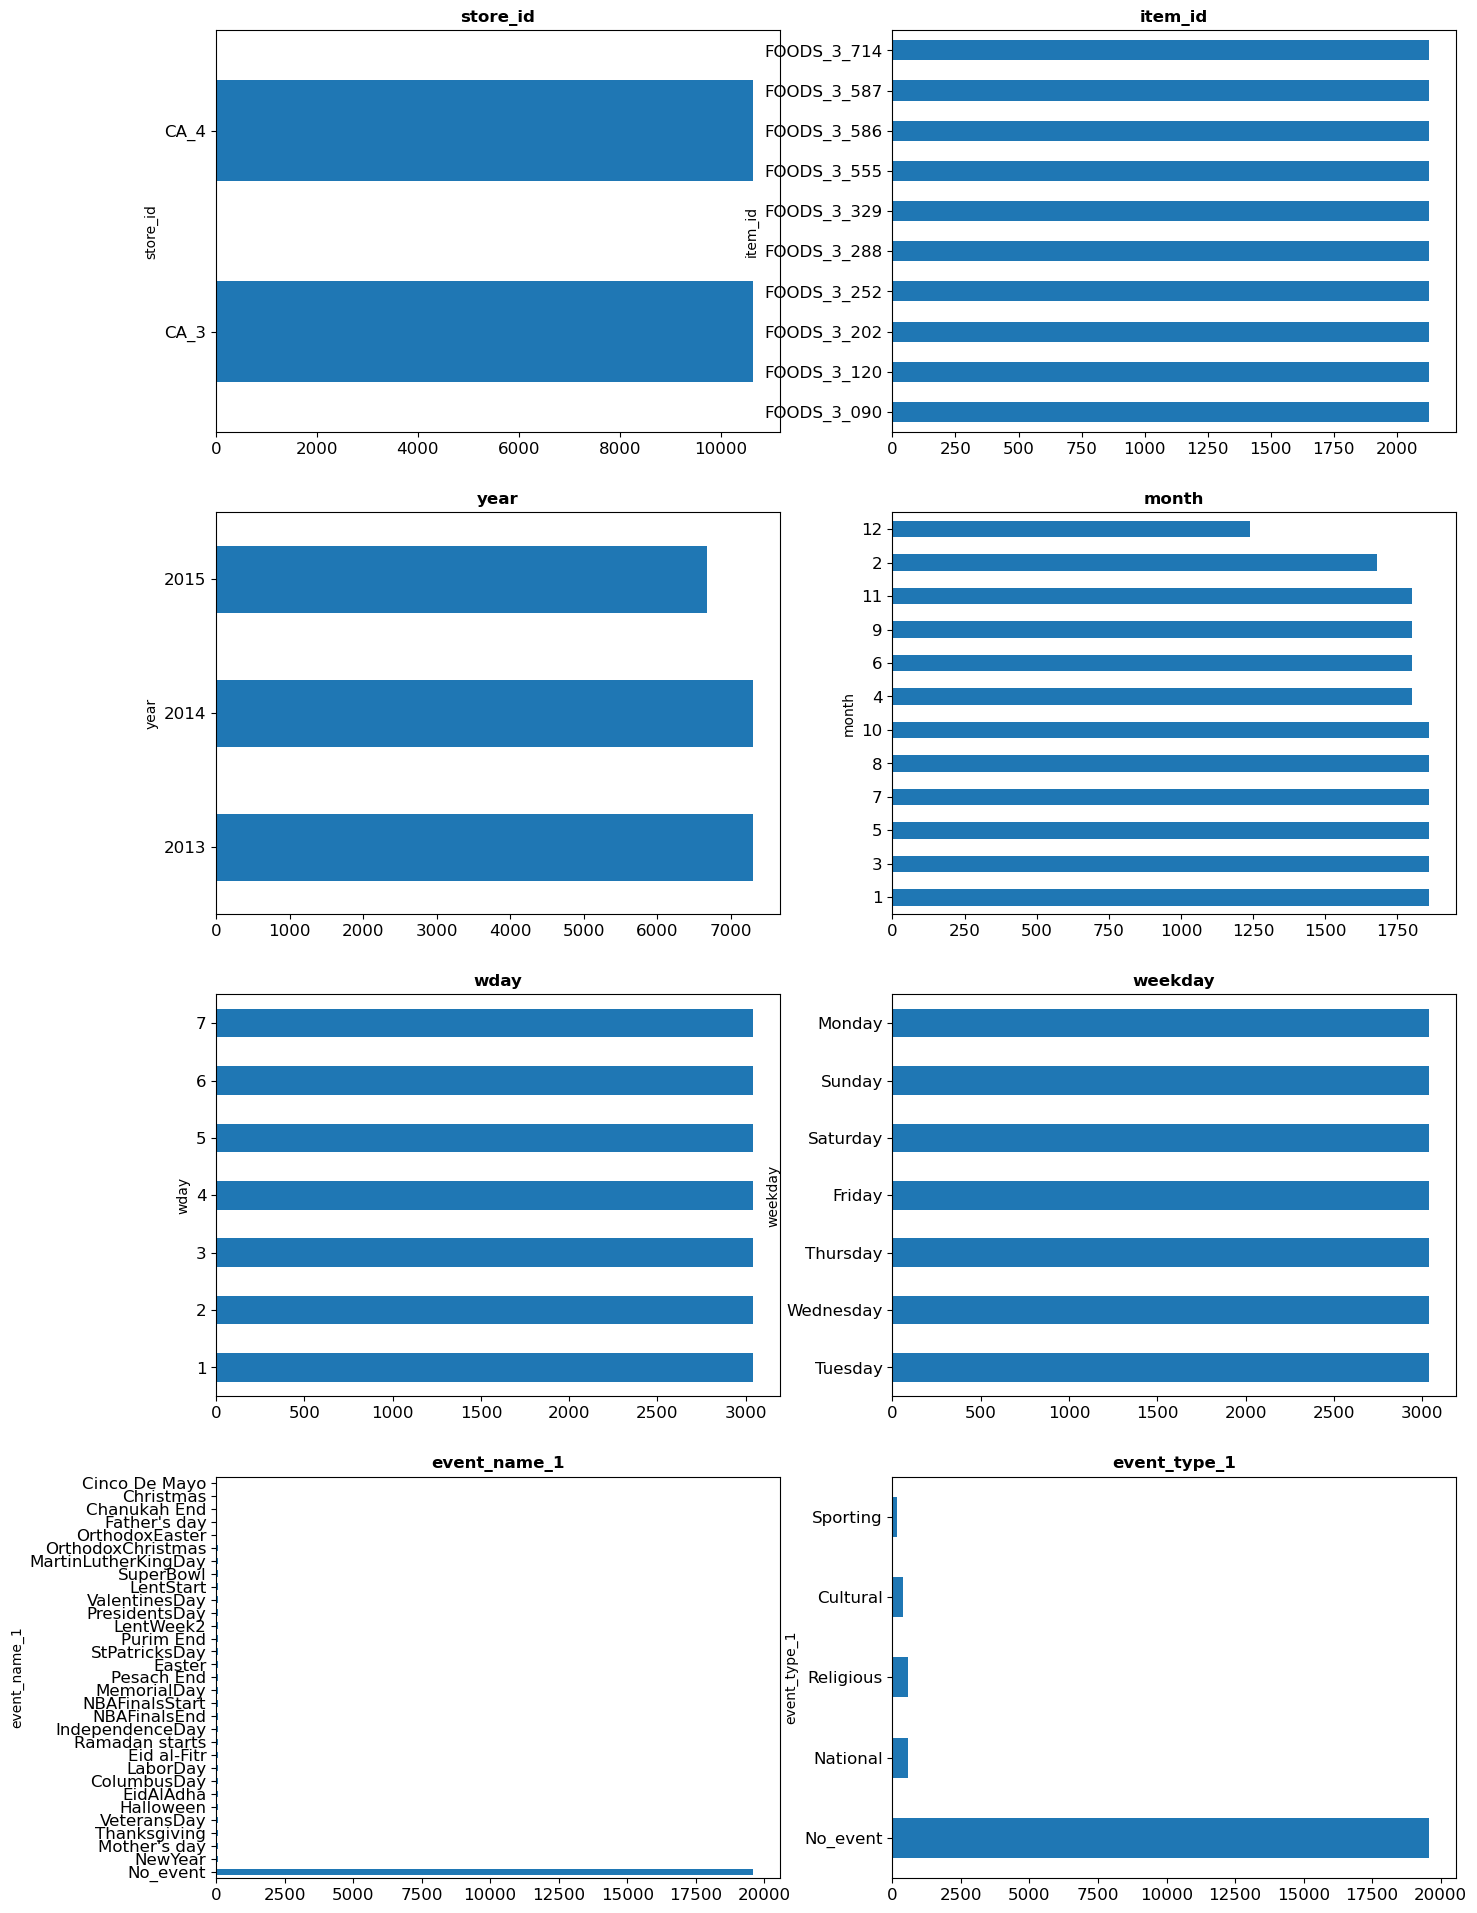

In [18]:
graph_eda_categorical(cat[include])

#### EDA Numeric

##### Statistic analysis

In [19]:
num.describe().T

count          mean        std      min      25%       50%  \
wm_yr_wk    21280.0  11415.022556  82.874752  11249.0  11335.0  11420.00   
sales       21280.0     28.874577  38.988147      0.0      6.0     18.00   
sell_price  21280.0      2.394261   1.236042      1.0      1.5      1.58   

                 75%       max  
wm_yr_wk    11506.00  11544.00  
sales          37.00    763.00  
sell_price      2.98      4.98

##### Graph analysis

Analyze the variables sales and sell_price

In [20]:
df = pd.concat([cat, num], axis=1)
print(f'{df.shape=}')
df.head()

df.shape=(21280, 12)


store_id      item_id      d  year month wday  weekday  \
date                                                                
2013-01-01     CA_3  FOODS_3_090  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_120  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_202  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_252  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_288  d_704  2013     1    4  Tuesday   

           event_name_1 event_type_1  wm_yr_wk  sales  sell_price  
date                                                               
2013-01-01      NewYear     National     11249      0        1.25  
2013-01-01      NewYear     National     11249     33        1.25  
2013-01-01      NewYear     National     11249      0        4.98  
2013-01-01      NewYear     National     11249      0        4.98  
2013-01-01      NewYear     National     11249     20        4.28

Global sales trend

<Axes: xlabel='date'>

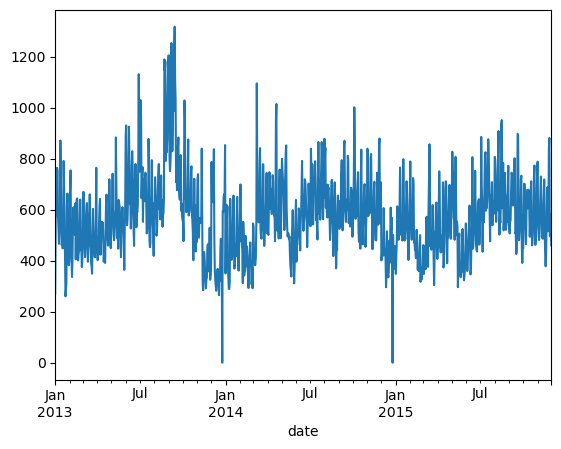

In [22]:
df.groupby('date').sales.sum().plot()

Sales trend by product

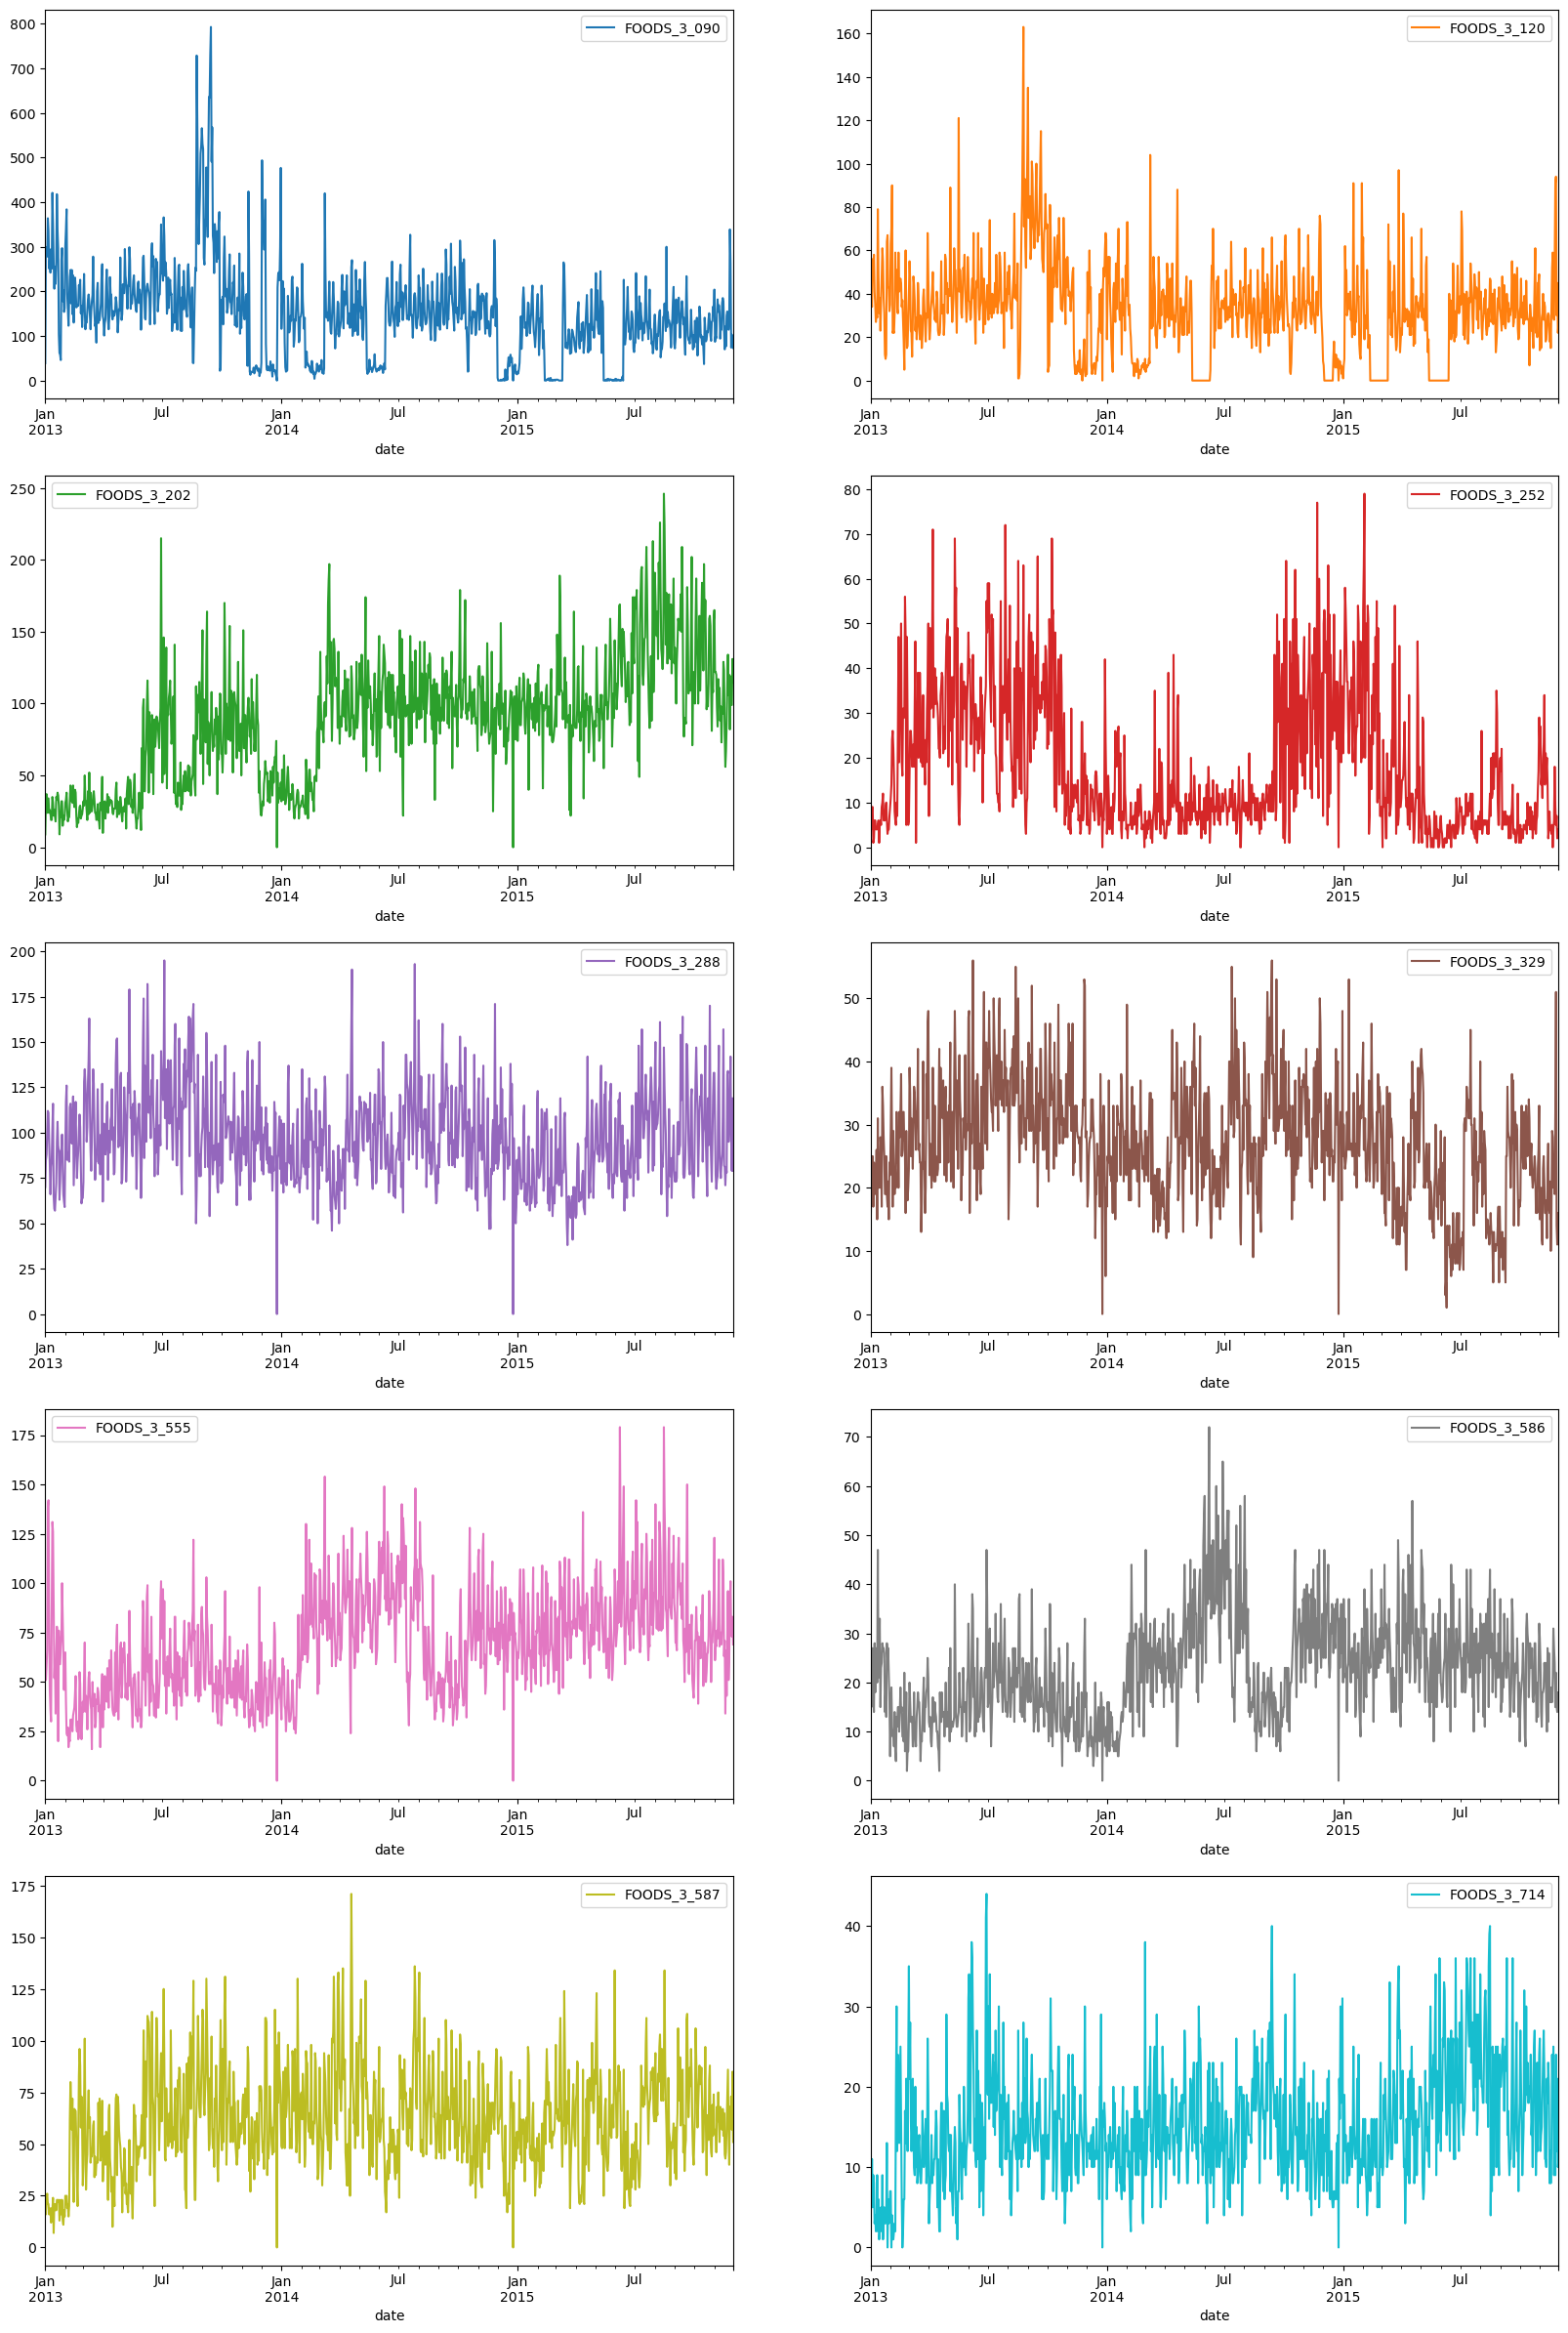

In [32]:
df.groupby(['date', 'item_id']).sales.sum().unstack().plot(
    subplots=True,
    layout=(5, 2),
    sharex=False,
    figsize=(20, 30)
)
plt.show()

Sales trend by store and by product

Store CA3

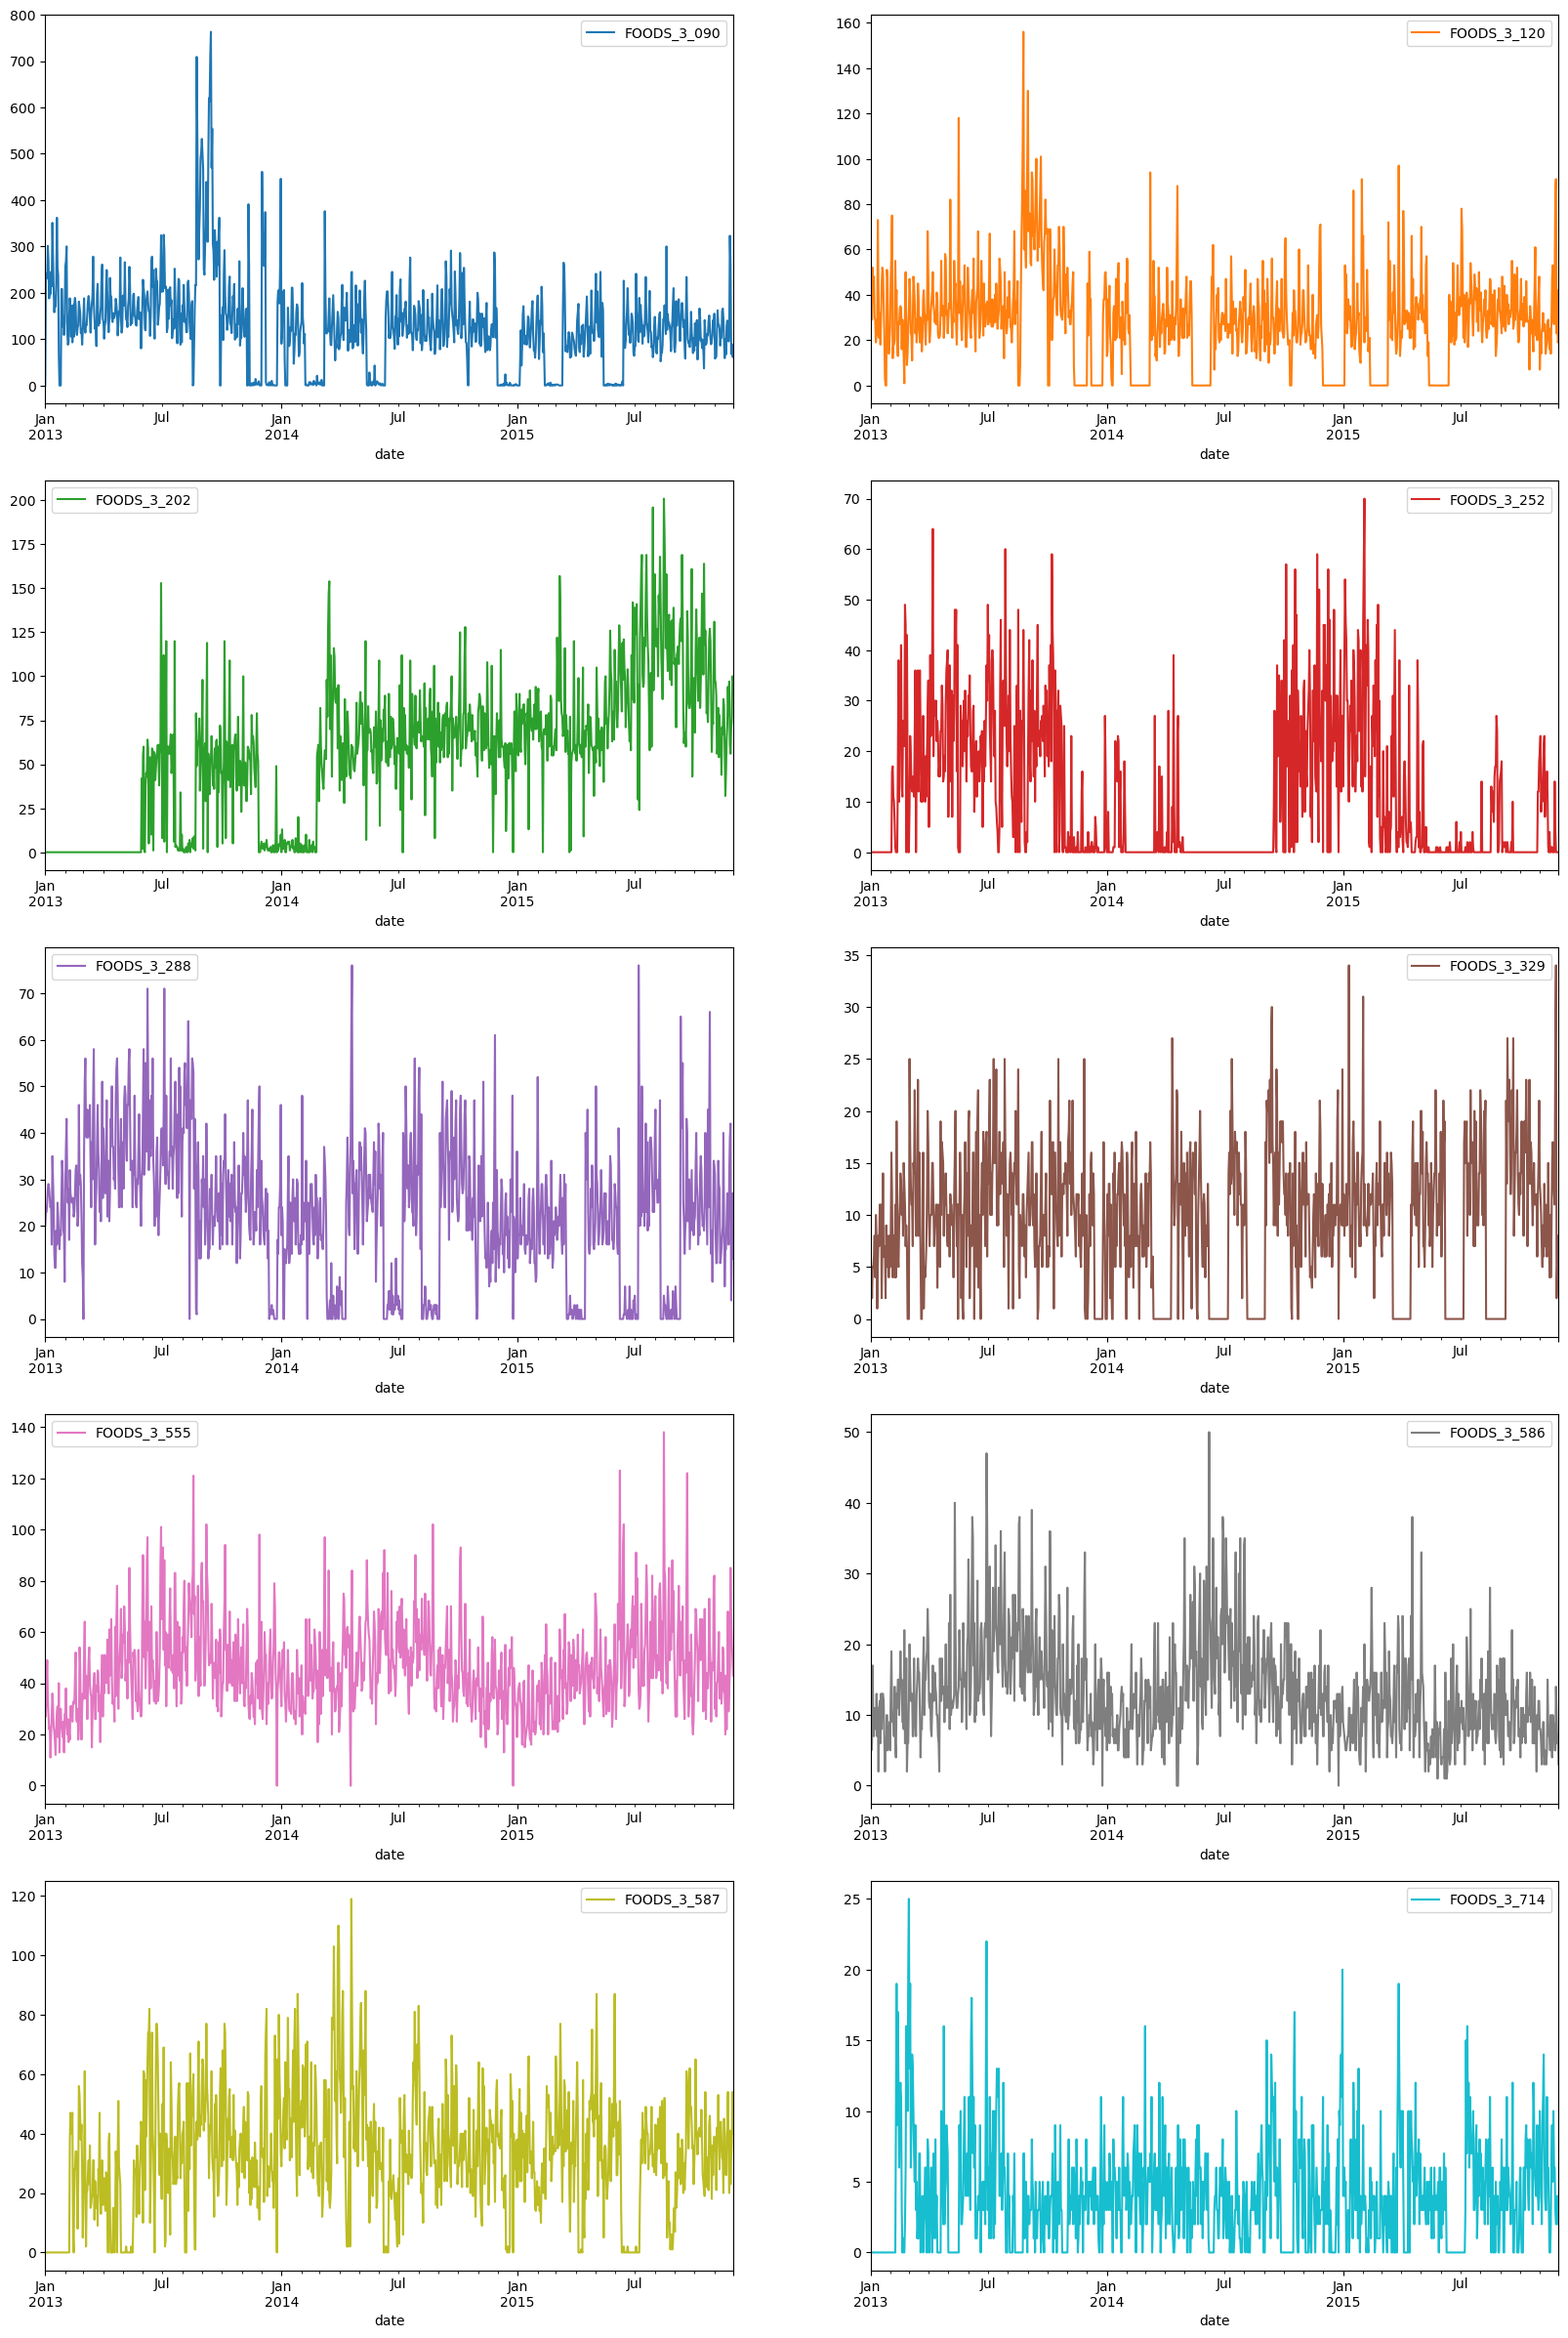

In [43]:
(df[df.store_id == 'CA_3'].groupby(['date', 'item_id'])
 .sales.sum()
 .unstack()
 .plot(subplots=True, layout=(5, 2), sharex=False, figsize=(20, 30))
)
plt.show()

Store CA4

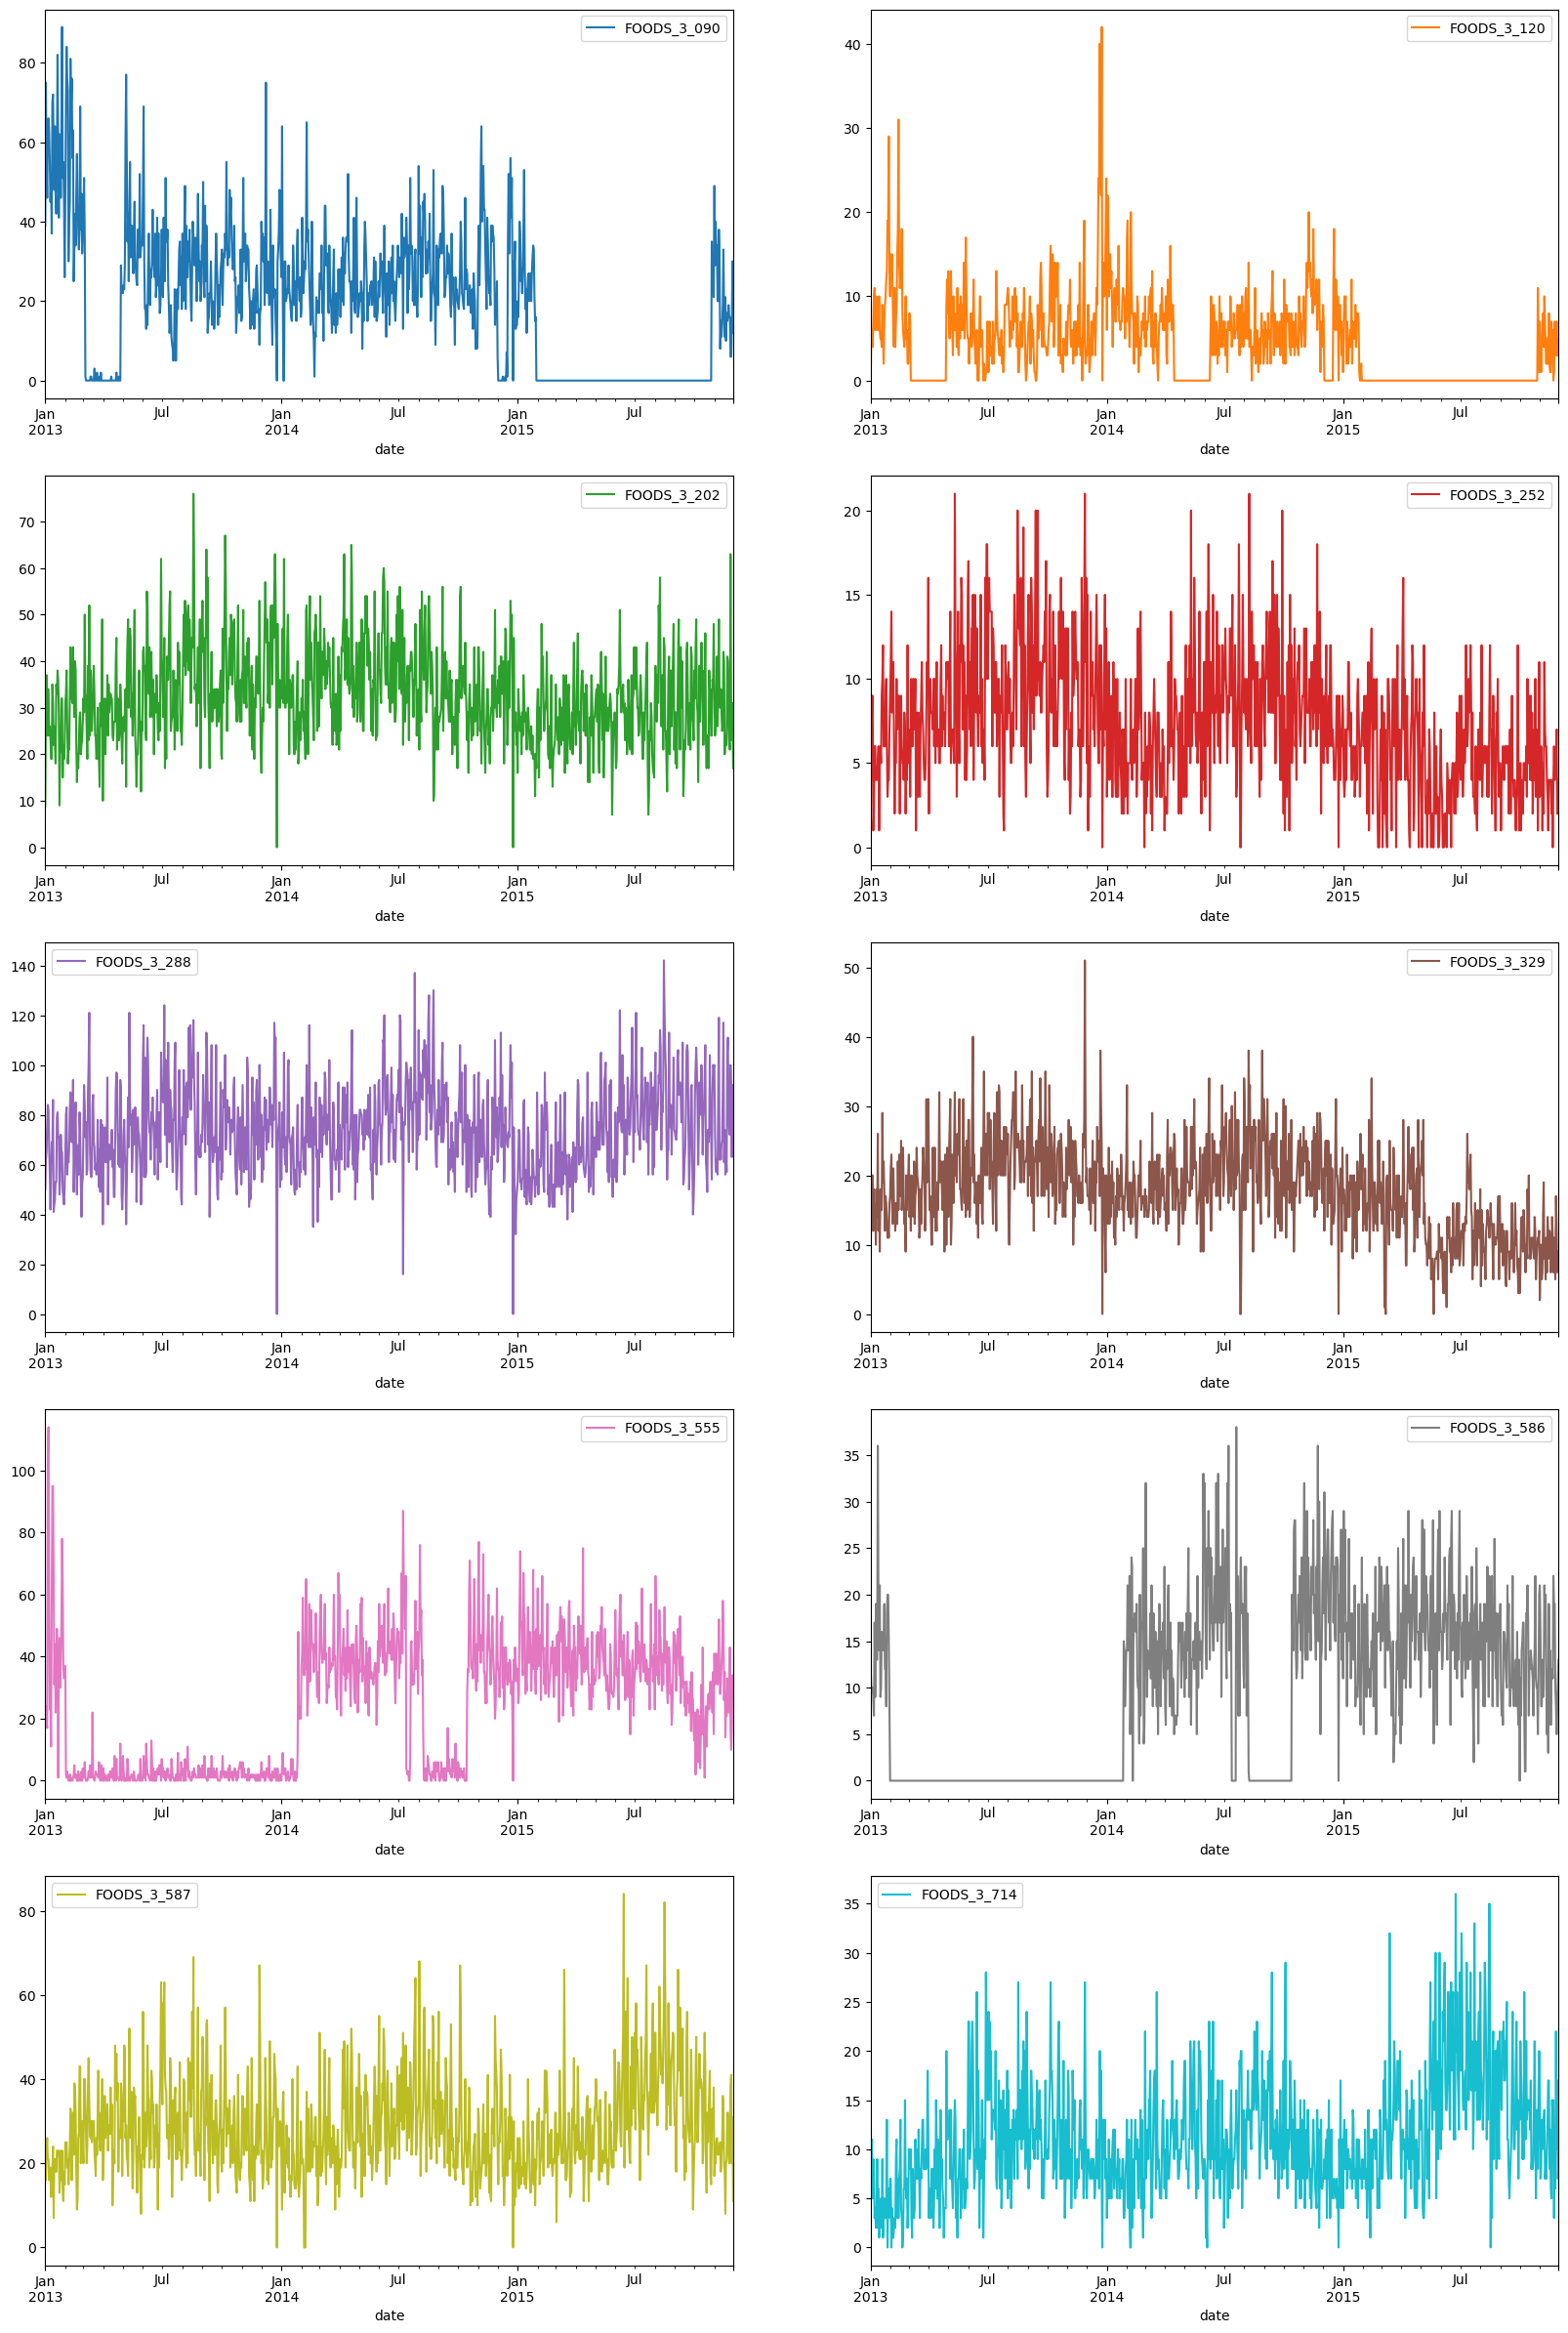

In [42]:
(df[df.store_id == 'CA_4'].groupby(['date', 'item_id'])
 .sales.sum()
 .unstack()
 .plot(subplots=True, layout=(5, 2), sharex=False, figsize=(20, 30))
)
plt.show()

Conclusions:

* Hierarchical structure
* Intermittent demand is detected in some of the products

Actions:

* Model at store-product level
* Generate a variable to capture the effect of intermittent demand
* Use tree-based algorithms: XGBoost o LightGBM


Price trend by product

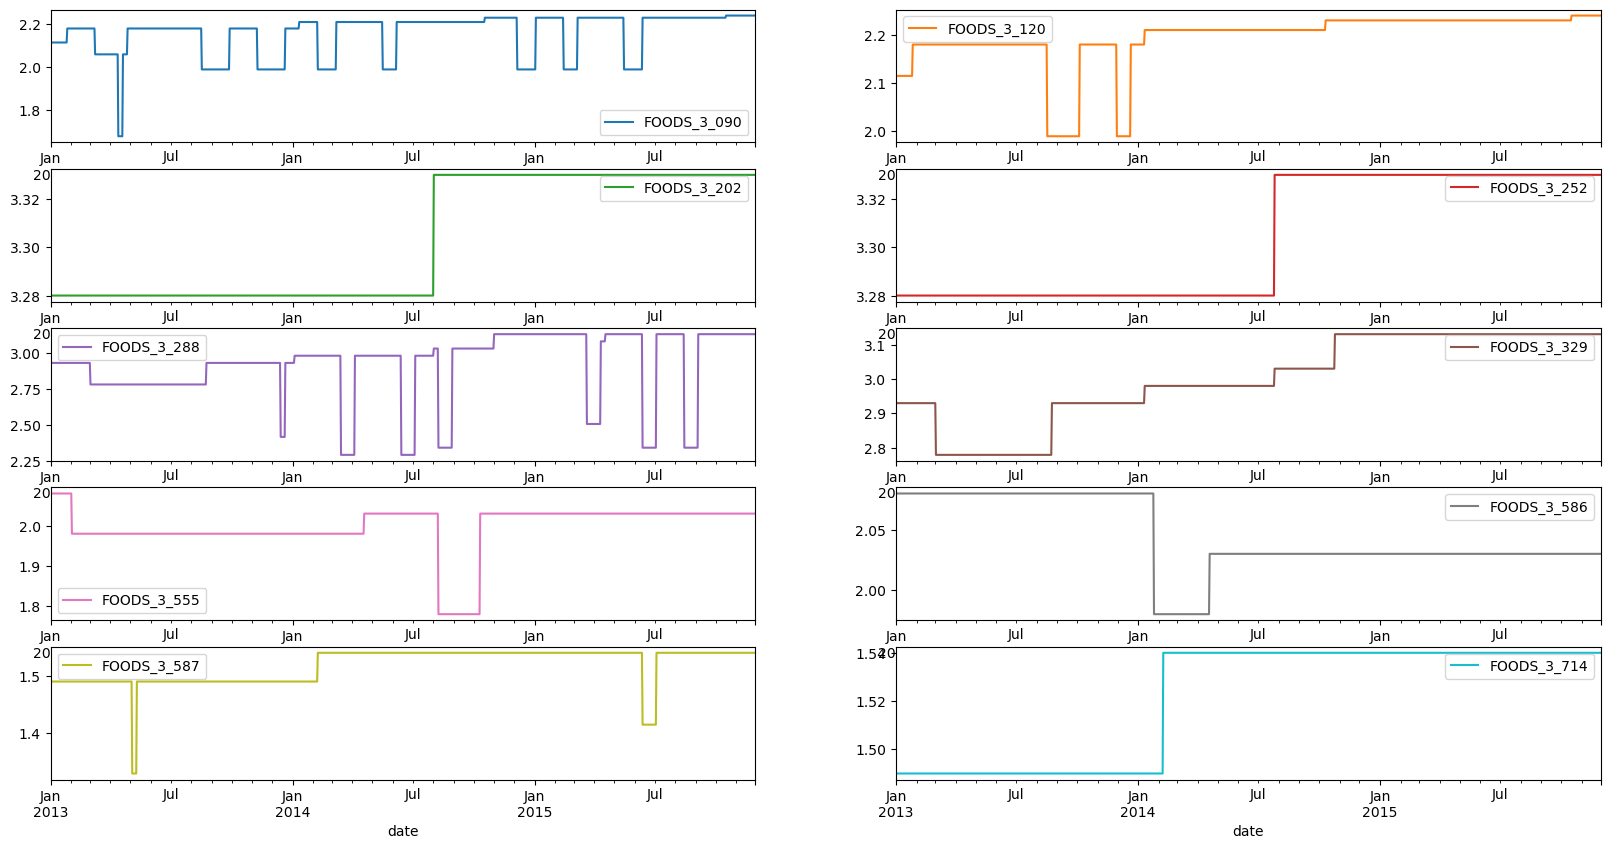

In [51]:
(df.groupby(['date', 'item_id'])
 .sell_price.mean()
 .unstack()
 .plot(subplots=True, layout=(5, 2), sharex=False, figsize=(20, 10))
)
plt.show()

Conclusions:

* Pricing policies vary greatly by product
* It would be useful to have a promotion calendar

Seasonality by product

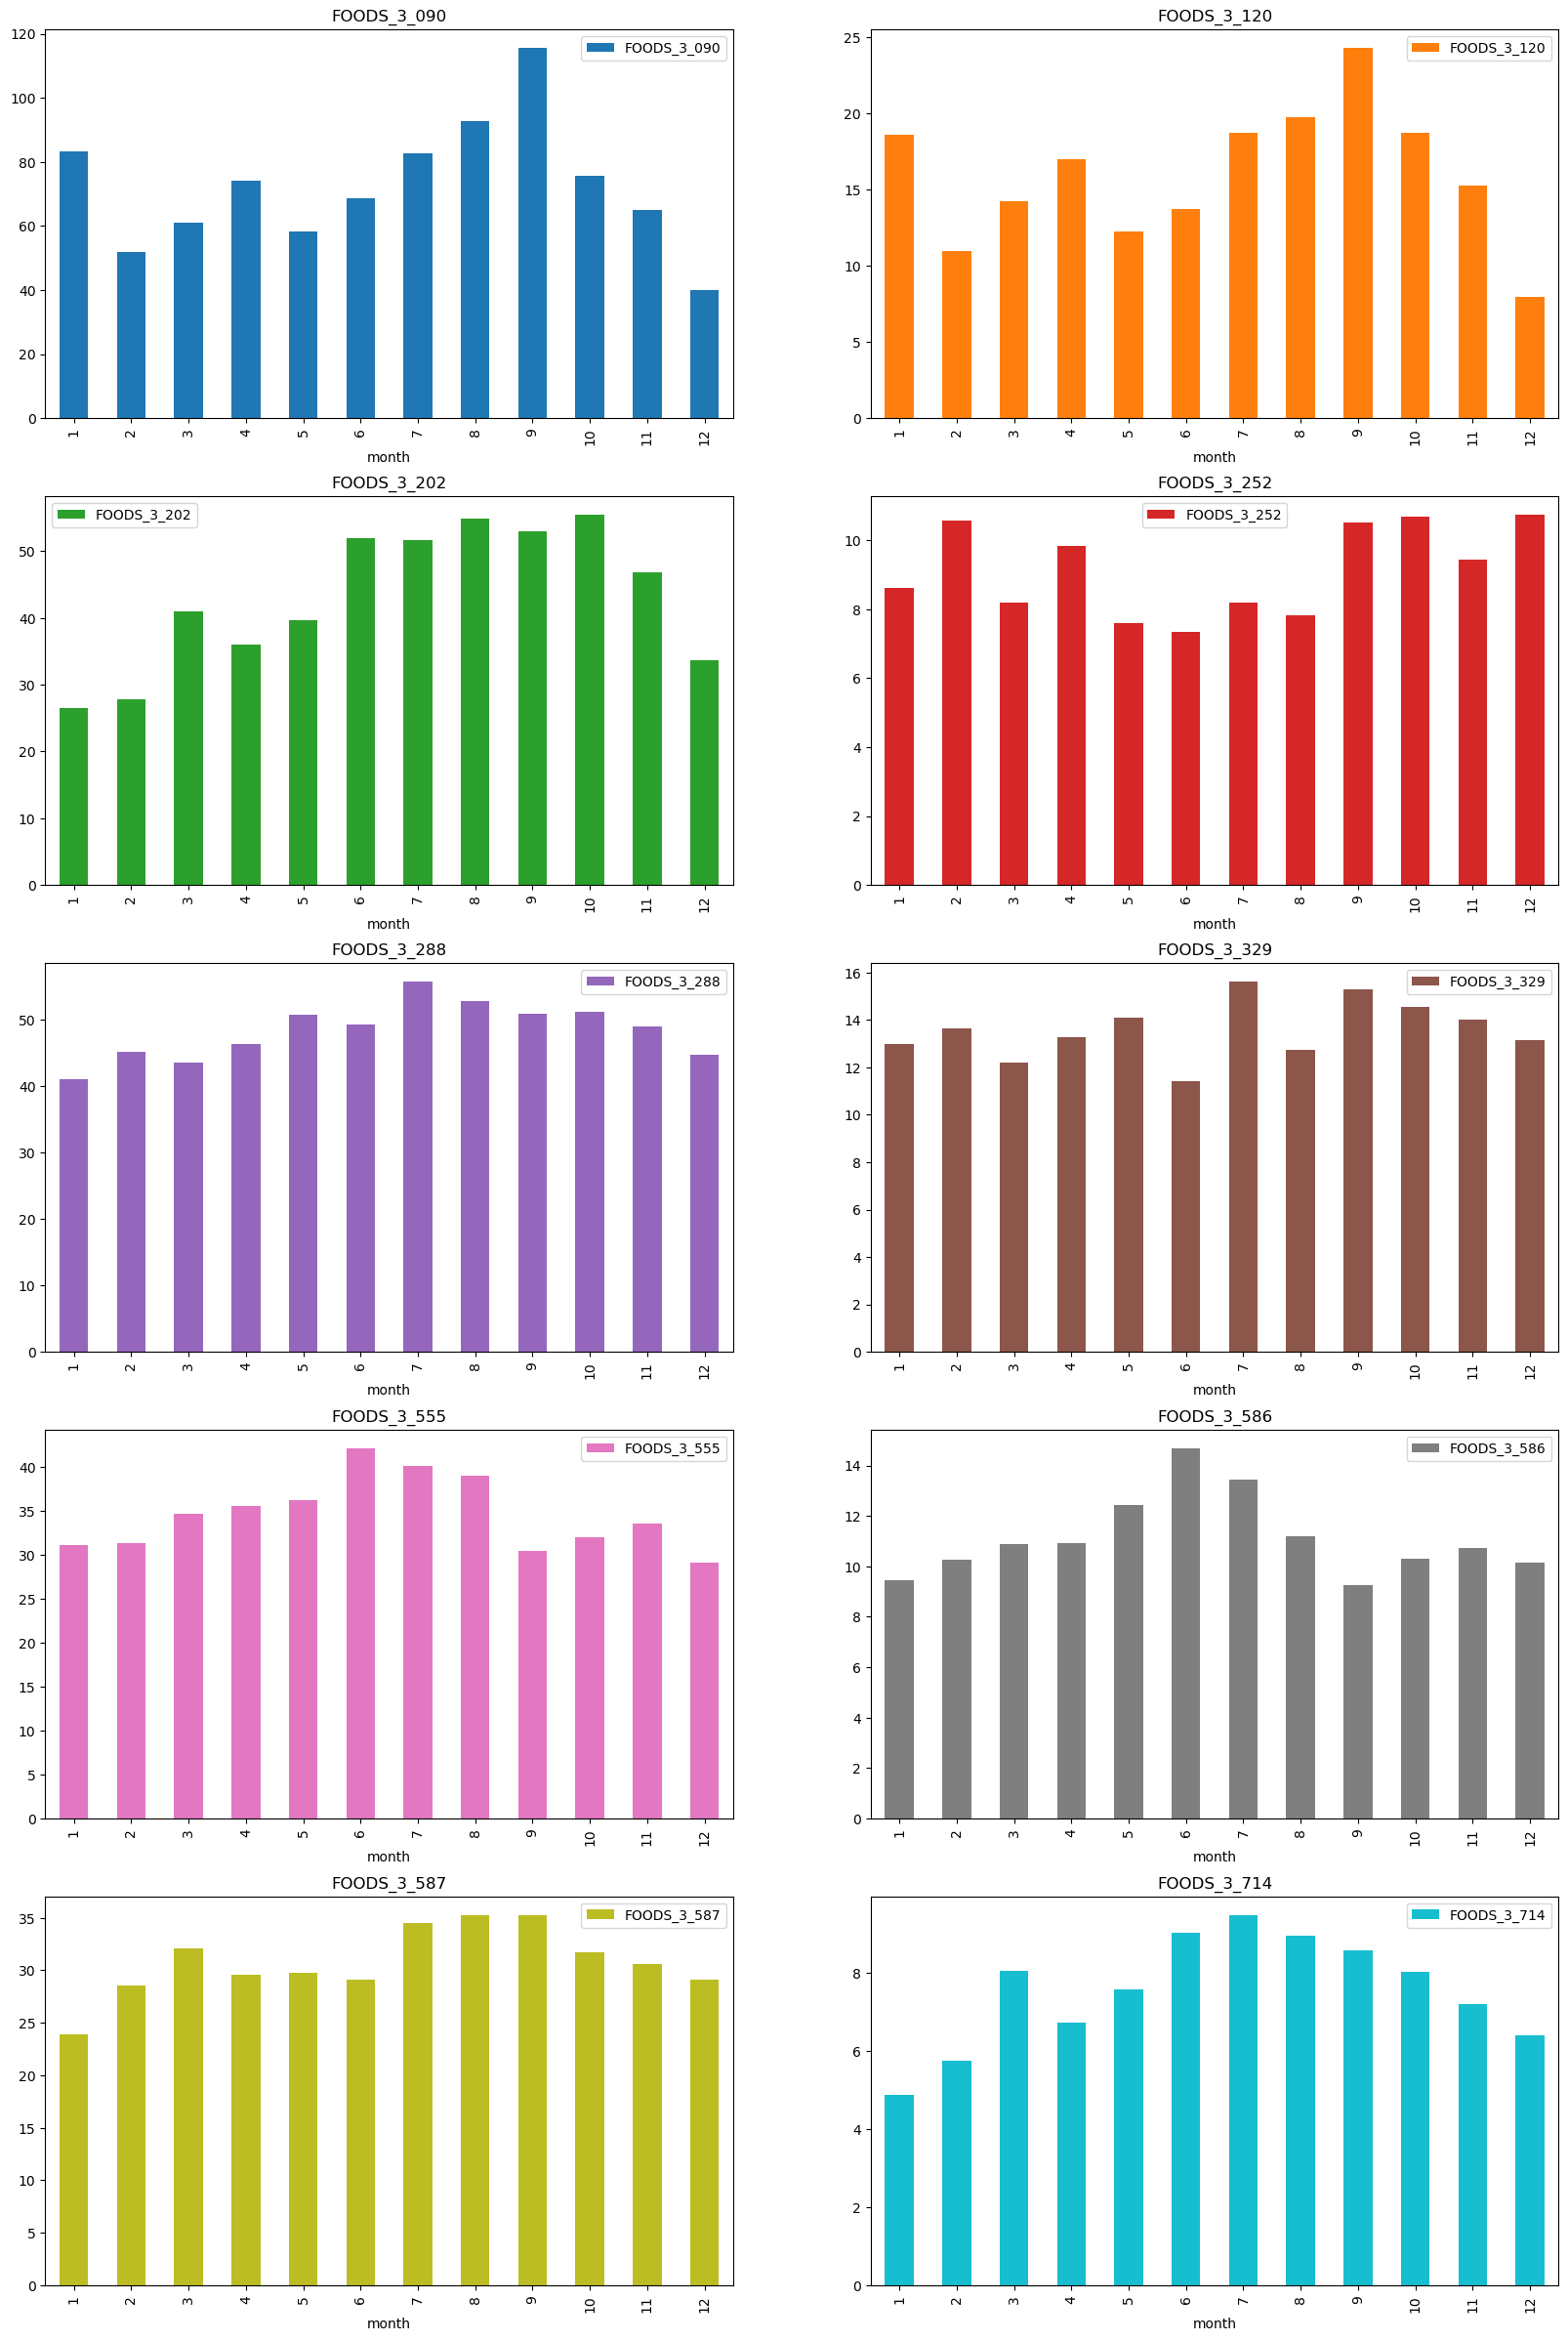

In [60]:
(df.groupby(['month', 'item_id'], observed=False)
 .sales.mean()
 .unstack()
 .plot.bar(subplots=True, layout=(5, 2), sharex=False, figsize=(20, 30))
)
plt.show()

In [61]:
df.head()

store_id      item_id      d  year month wday  weekday  \
date                                                                
2013-01-01     CA_3  FOODS_3_090  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_120  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_202  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_252  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_288  d_704  2013     1    4  Tuesday   

           event_name_1 event_type_1  wm_yr_wk  sales  sell_price  
date                                                               
2013-01-01      NewYear     National     11249      0        1.25  
2013-01-01      NewYear     National     11249     33        1.25  
2013-01-01      NewYear     National     11249      0        4.98  
2013-01-01      NewYear     National     11249      0        4.98  
2013-01-01      NewYear     National     11249     20        4.28

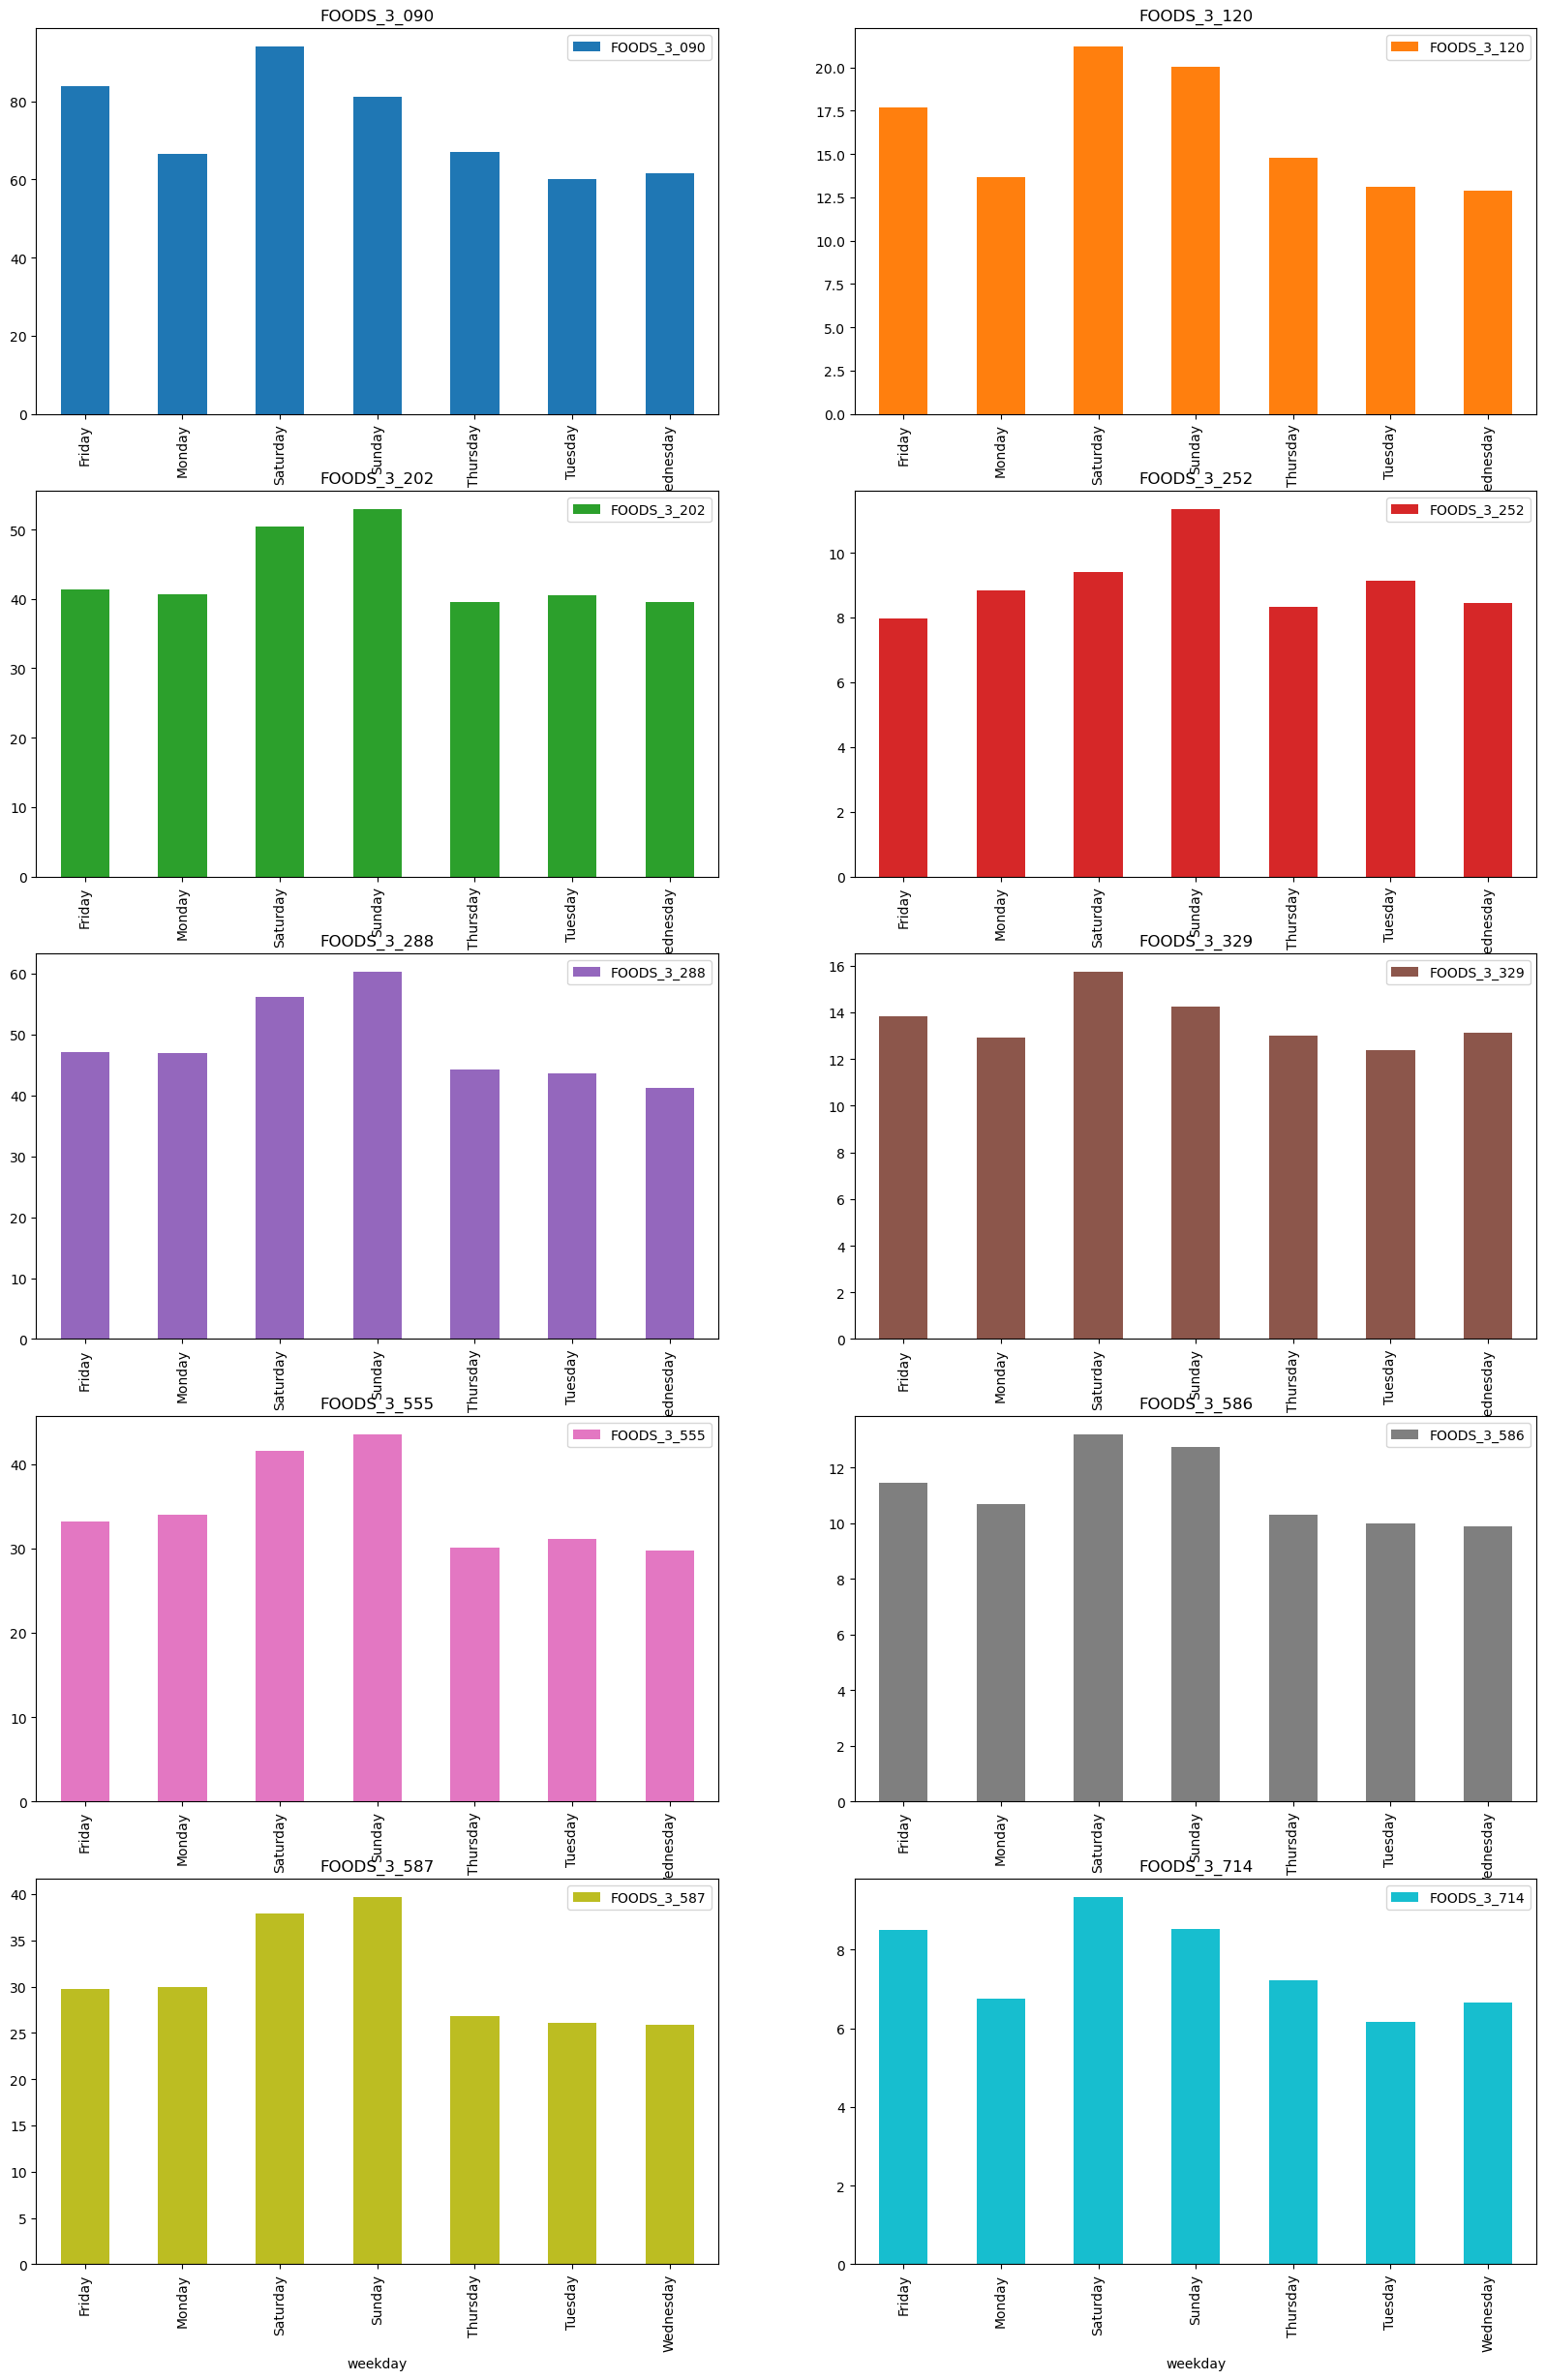

In [62]:
(df.groupby(['weekday', 'item_id'], observed=False)
 .sales.mean()
 .unstack()
 .plot.bar(subplots=True, layout=(5, 2), sharex=False, figsize=(20, 30))
)
plt.show()

Seasonality by event

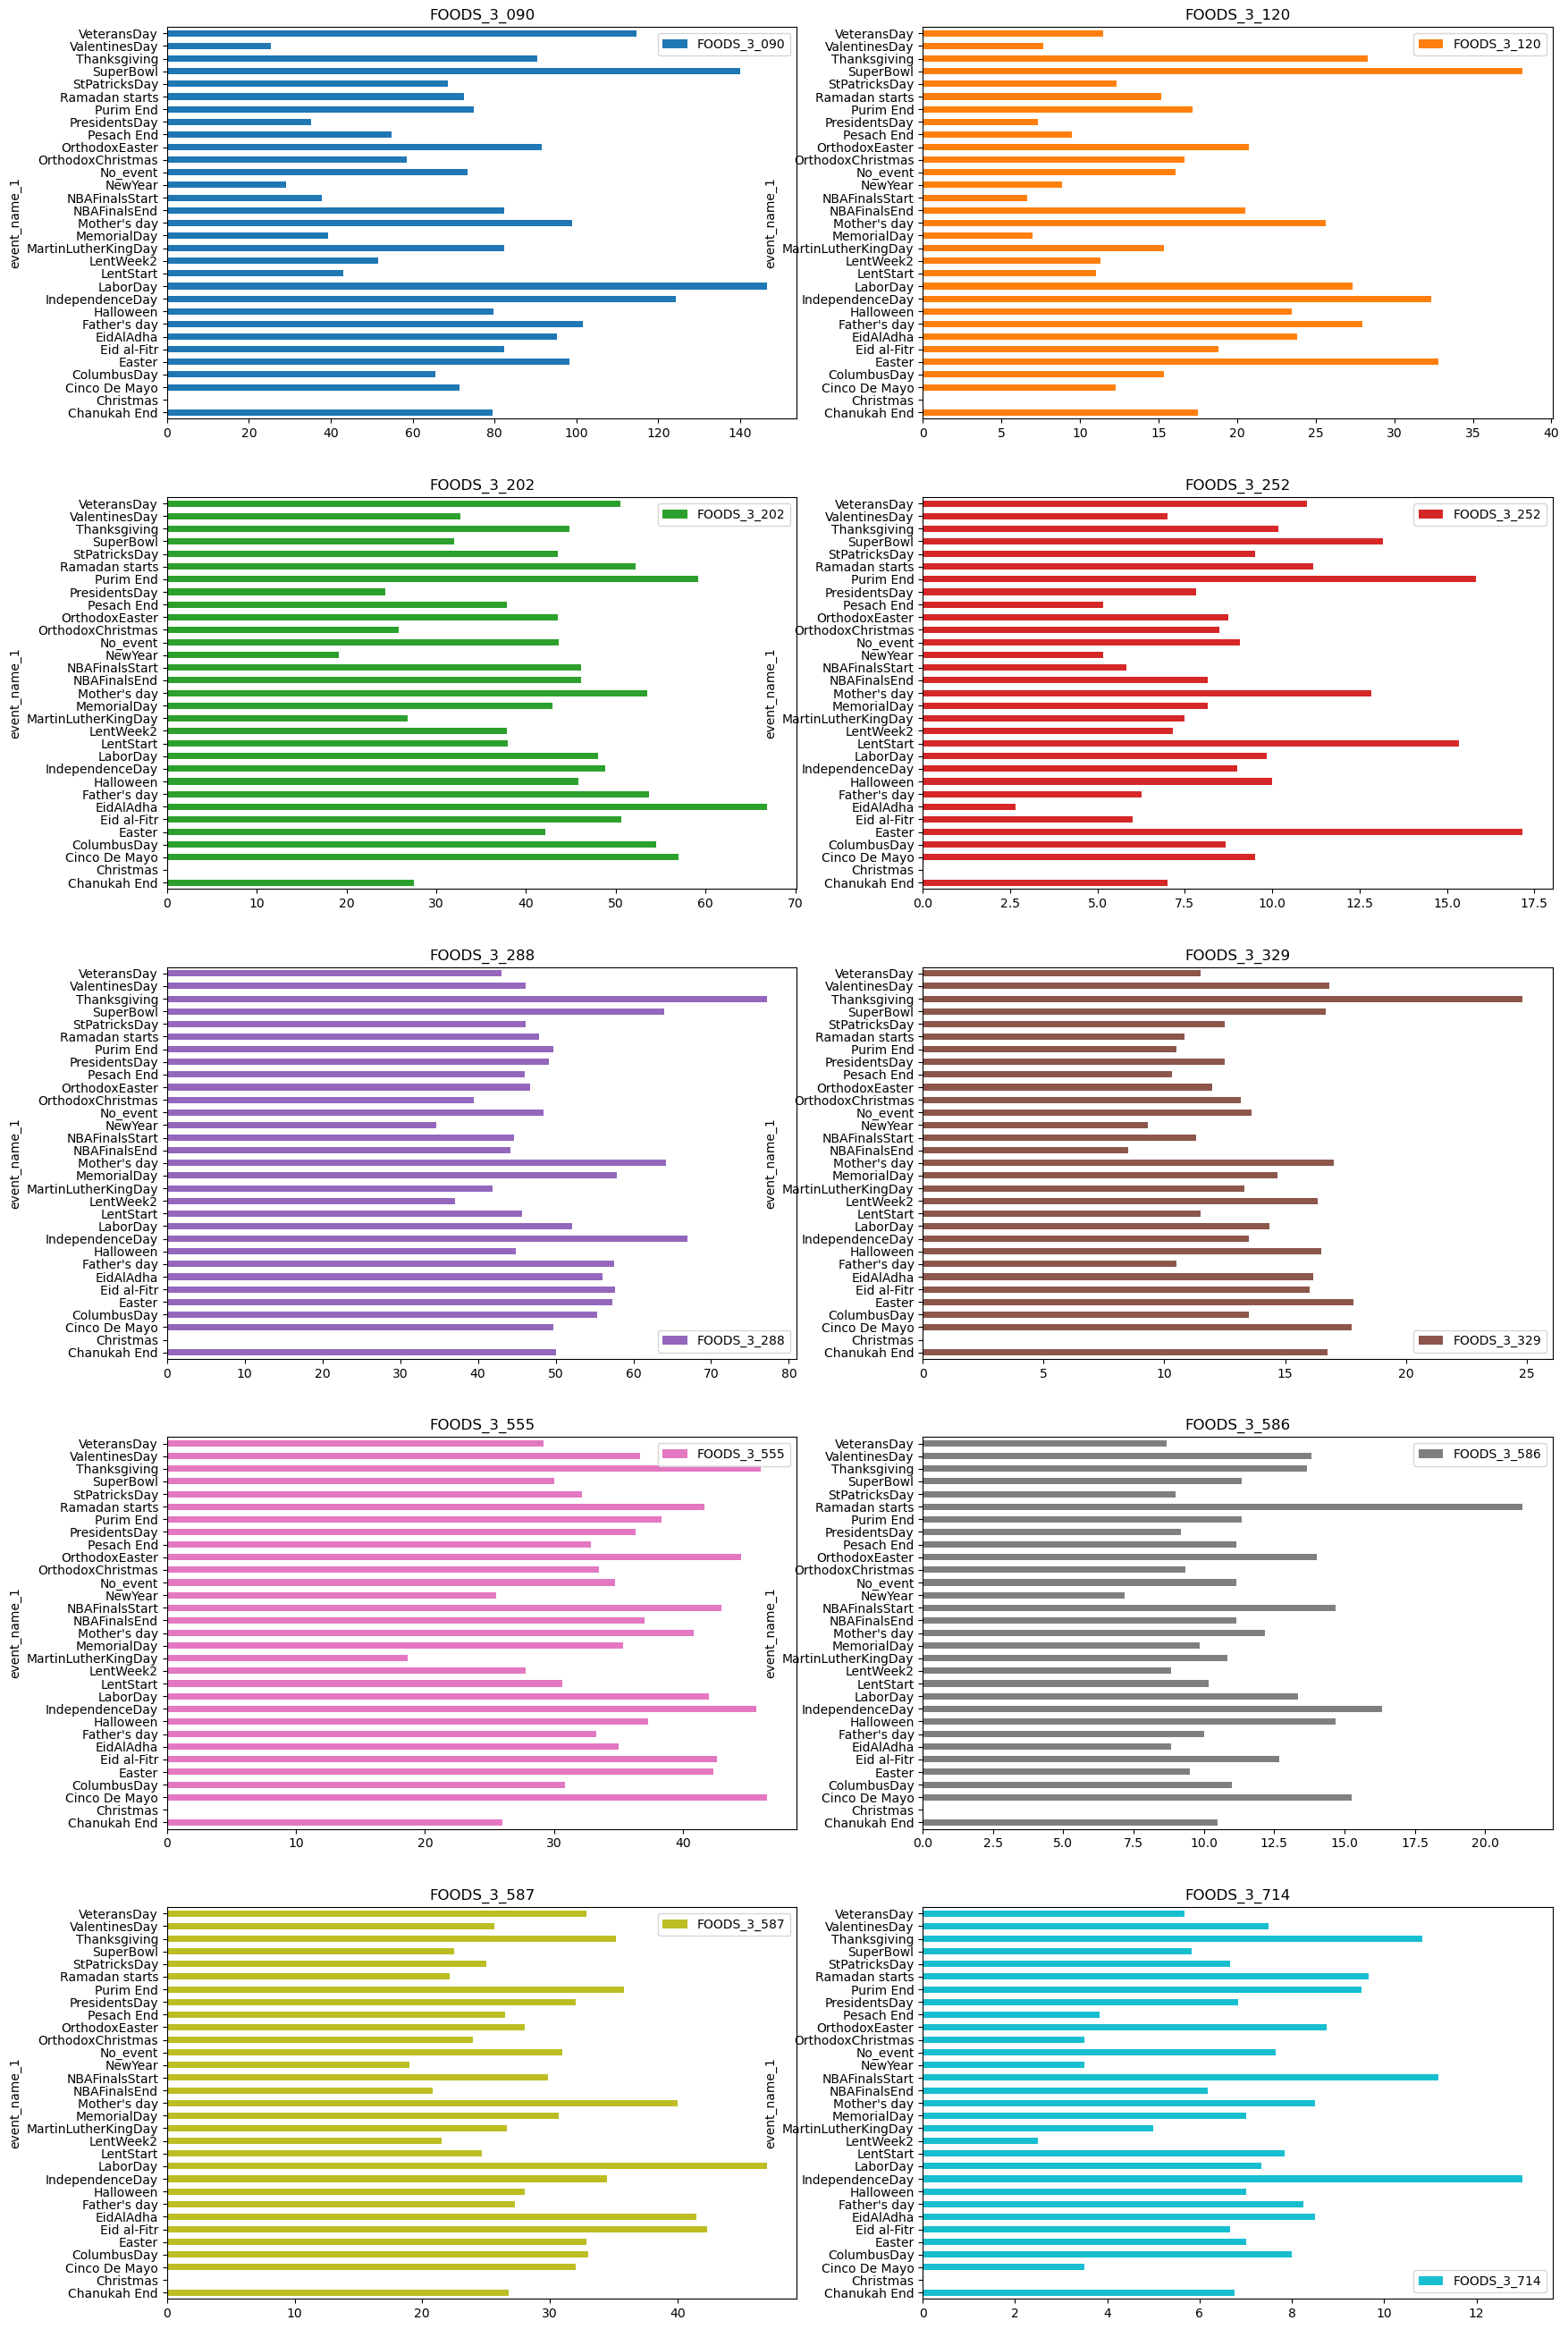

In [69]:
(df.groupby(['event_name_1', 'item_id'])
 .sales.mean()
 .unstack()
 .plot.barh(subplots=True, sharex=False, layout=(5, 2), figsize=(20, 33))
)
plt.show()

Seasionality by event type

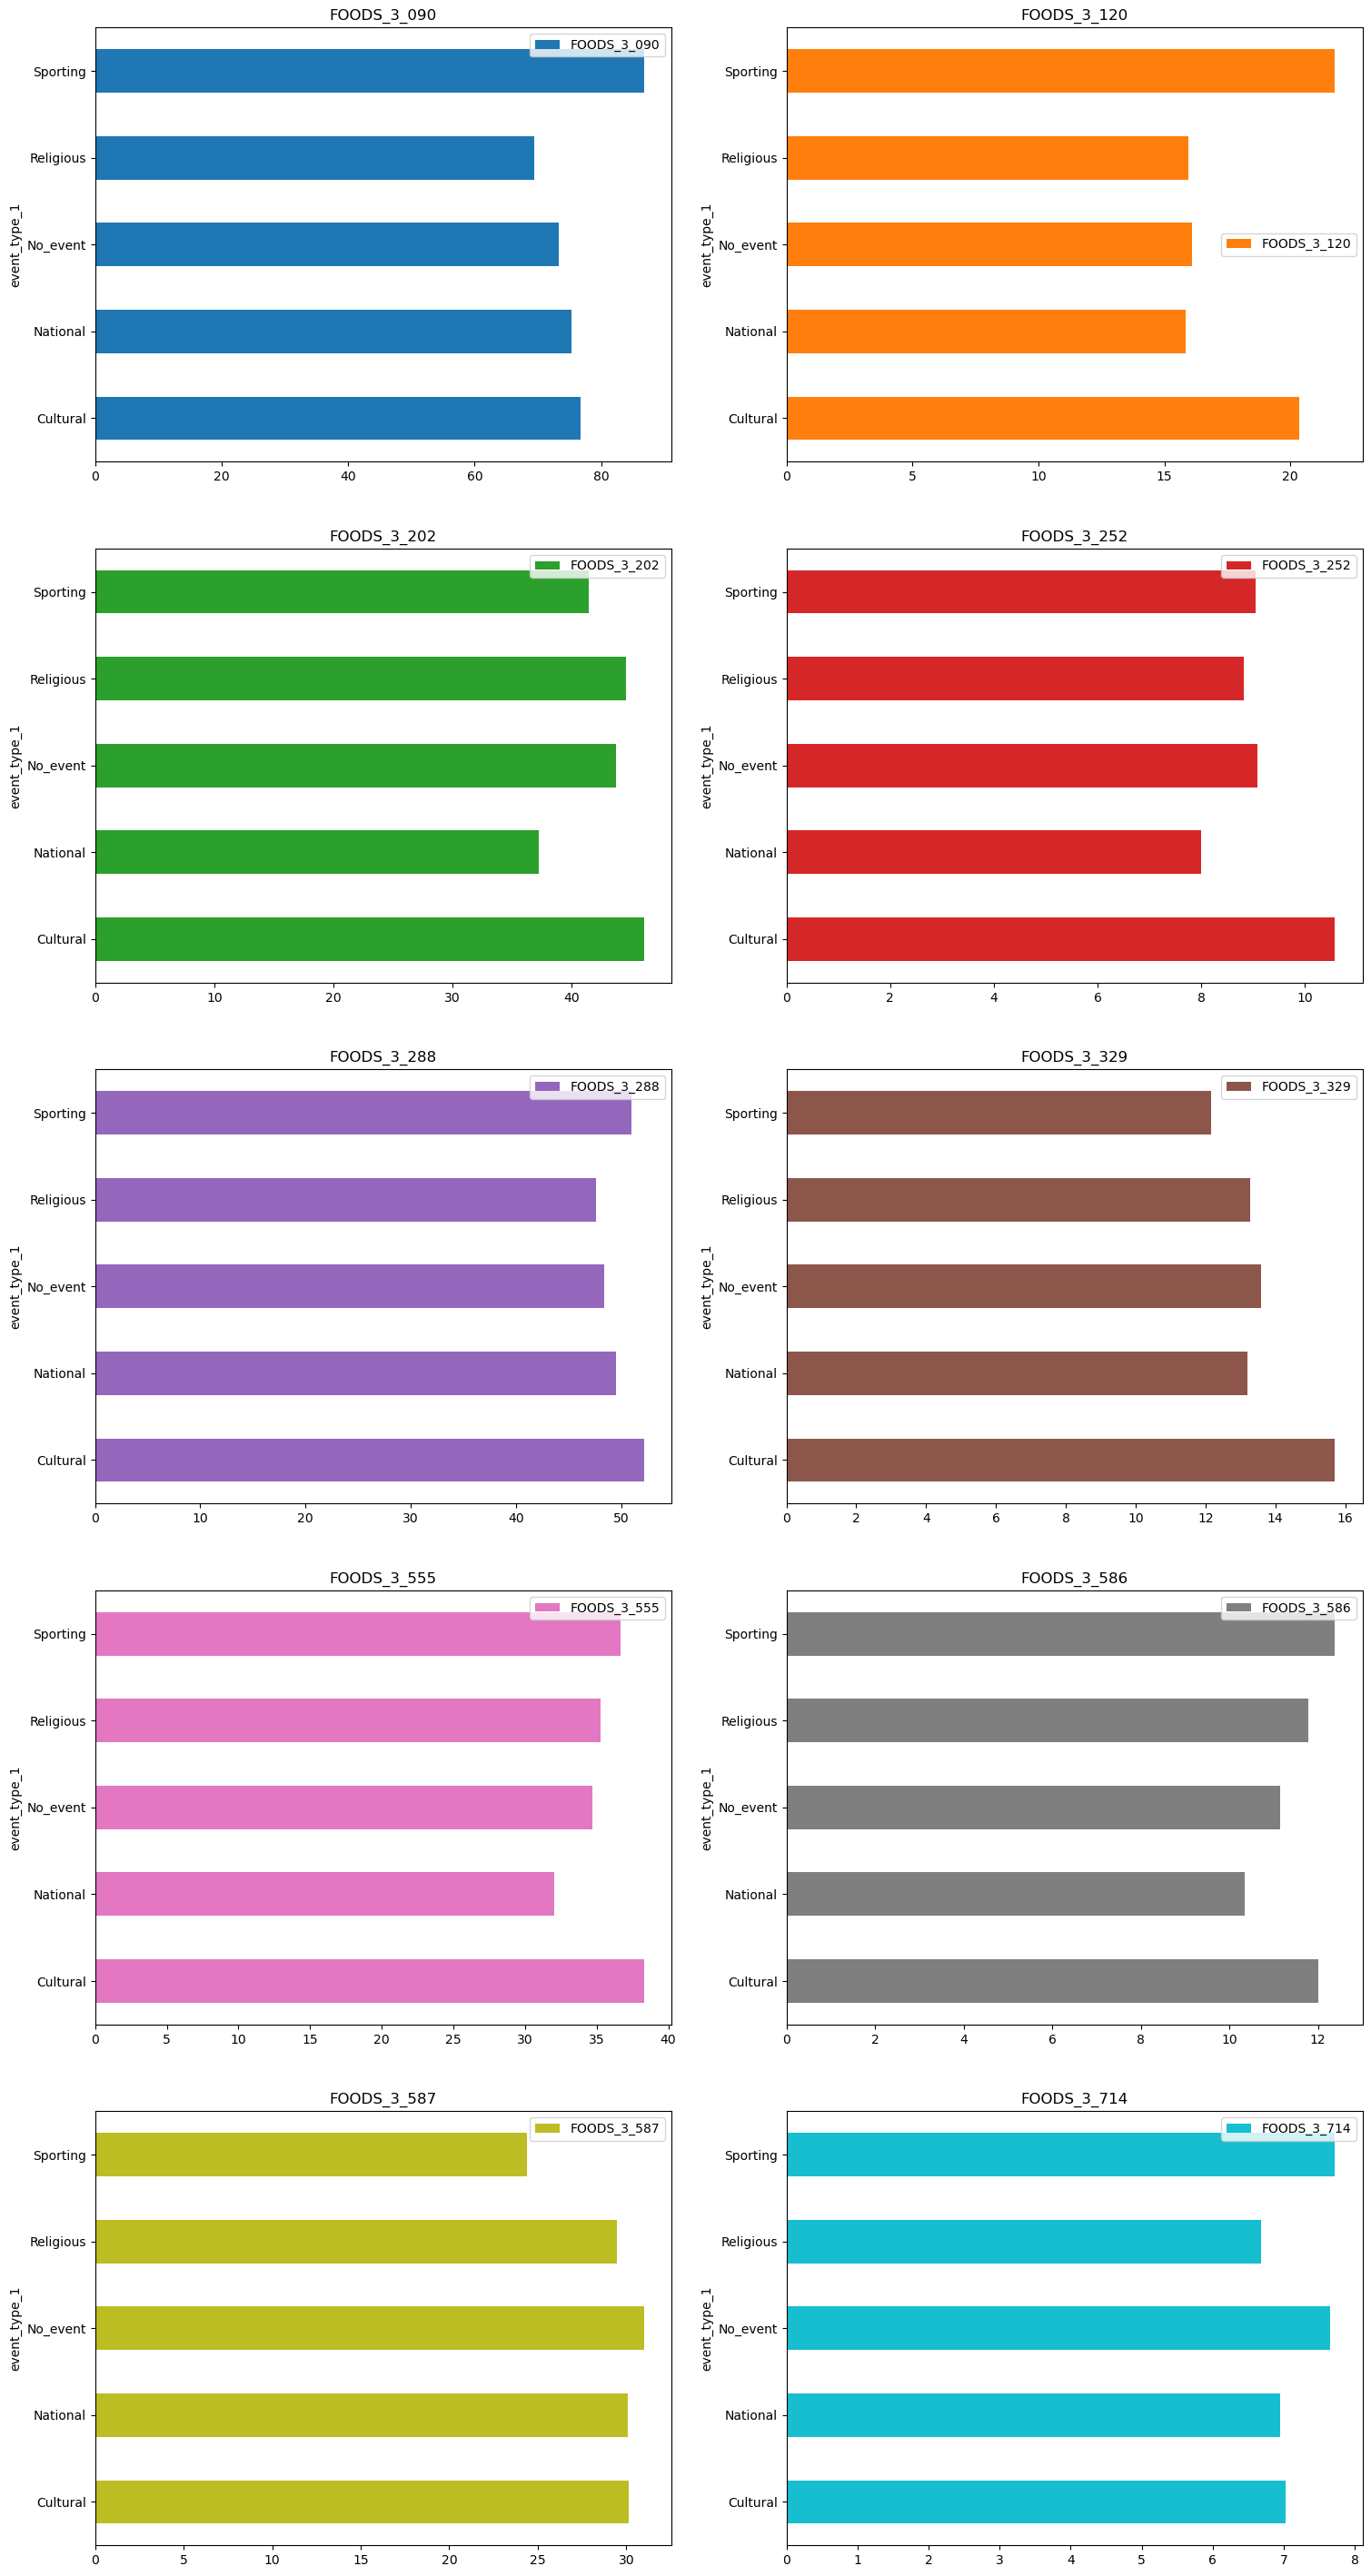

In [79]:
(df.groupby(['event_type_1', 'item_id'])
 .sales.mean()
 .unstack()
 .plot.barh(subplots=True, layout=(5, 2), sharex=False, figsize=(18, 36))
)
plt.show()

Conclusions:

* All of these variables seem to affect sales levels.

#### Guardar datasets EDA

In [ ]:
cat.to_pickle('../data/cat_eda.pickle')
num.to_pickle('../data/num_eda.pickle')

### Transform variables

##### Load data

In [2]:
cat = pd.read_pickle('../data/cat_eda.pickle')
num = pd.read_pickle('../data/num_eda.pickle')

#### Generate variables

##### Variables to model intermittent demand

Variable to identify how many days in a row have passed with zero sales.

In [3]:
df = pd.concat([cat, num], axis=1)
print(f'{df.shape=}')
df.head()

df.shape=(21280, 12)


store_id      item_id      d  year month wday  weekday  \
date                                                                
2013-01-01     CA_3  FOODS_3_090  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_120  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_202  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_252  d_704  2013     1    4  Tuesday   
2013-01-01     CA_3  FOODS_3_288  d_704  2013     1    4  Tuesday   

           event_name_1 event_type_1  wm_yr_wk  sales  sell_price  
date                                                               
2013-01-01      NewYear     National     11249      0        1.25  
2013-01-01      NewYear     National     11249     33        1.25  
2013-01-01      NewYear     National     11249      0        4.98  
2013-01-01      NewYear     National     11249      0        4.98  
2013-01-01      NewYear     National     11249     20        4.28

Generate function to determine stock out for n days

In [4]:
def determine_stock_out(sales, n=5):
    zero_sales = pd.Series(np.where(sales==0, 1, 0))
    num_zeros = zero_sales.rolling(n).sum()
    stock_out = np.where(num_zeros==n, 1, 0)
    return stock_out

In [5]:
df = df.sort_values(['store_id', 'item_id', 'date'])

Generate stockout variables for n = 3, 7, 15

In [6]:
df['stock_out_3'] = (
    df.groupby(['store_id', 'item_id'])
    .sales
    .transform(lambda x: determine_stock_out(x, 3))
)

In [7]:
df['stock_out_7'] = (
    df.groupby(['store_id', 'item_id'])
    .sales
    .transform(lambda x: determine_stock_out(x, 7))
)

In [8]:
df['stock_out_15'] = (
    df.groupby(['store_id', 'item_id'])
    .sales
    .transform(lambda x: determine_stock_out(x, 15))
)

##### Variables lags

sales: lags of up to 15 days

sell_price: lags of up to 7 days

stock_out: 1 day lags

In [9]:
def generate_lags(df, variable, num_lags=7):
    """Generates lagged versions of a specific variable in a DataFrame.
    """
    lags = pd.DataFrame({
        f'{variable}_lag_{lag}': df[variable].shift(lag)
        for lag in range(1, num_lags + 1)
    })
    
    return(lags)

In [10]:
lags_sales_df = (
    df.groupby(['store_id', 'item_id'])
    .apply(lambda x: generate_lags(x, 'sales', 15))
    .reset_index()
    .set_index('date')
)

In [11]:
lags_sell_price_df = (
    df.groupby(['store_id', 'item_id'])
    .apply(lambda x: generate_lags(x, 'sell_price', 7))
    .reset_index()
    .set_index('date')
)

In [12]:
lags_stock_out_3_df = (
    df.groupby(['store_id', 'item_id'])
    .apply(lambda x: generate_lags(x, 'stock_out_3', 1))
    .reset_index()
    .set_index('date')
)

In [13]:
lags_stock_out_7_df = (
    df.groupby(['store_id', 'item_id'])
    .apply(lambda x: generate_lags(x, 'stock_out_7', 1))
    .reset_index()
    .set_index('date')
)

In [14]:
lags_stock_out_15_df = (
    df.groupby(['store_id', 'item_id'])
    .apply(lambda x: generate_lags(x, 'stock_out_15', 1))
    .reset_index()
    .set_index('date')
)

##### Moving window variables

Generate moving window variables on the sales variable in the 15-day range:

* moving minimum
* moving average
* mobile maximum

Generate functions to calculate moving windows

In [15]:
def calculate_min_mobile(df, variable, num_periods=7):
    """Calculates the rolling minimums for a specific variable using historical data
    shifted down in a period for each specified number of periods.
    """
    minm = pd.DataFrame({
        f'{variable}_minm_{roll}': df[variable].shift(1).rolling(roll).min()
        for roll in range(2, num_periods + 1)
    })
    
    return(minm)

def calculate_moving_average(df, variable, num_periods=7):
    """Calculates the rolling averages for a specific variable using historical data
    shifted down in a period for each specified number of periods.
    """
    mm = pd.DataFrame({
        f'{variable}_mm_{roll}': df[variable].shift(1).rolling(roll).mean()
        for roll in range(2, num_periods + 1)
    })
    
    return(mm)

def calculate_max_mobile(df, variable, num_periods=7):
    """Calculates the rolling maximums for a specific variable using historical data
    shifted down in a period for each specified number of periods.
    """
    maxm = pd.DataFrame({
        f'{variable}_maxm_{roll}': df[variable].shift(1).rolling(roll).max()
        for roll in range(2, num_periods + 1)
    })
    
    return(maxm)

In [16]:
min_mobile_df = (
    df.groupby(['store_id', 'item_id'])
    .apply(lambda x: calculate_min_mobile(x, 'sales', 15))
    .reset_index()
    .set_index('date')
)

In [17]:
moving_mobile_df = (
    df.groupby(['store_id', 'item_id'])
    .apply(lambda x: calculate_moving_average(x, 'sales', 15))
    .reset_index()
    .set_index('date')
)

In [18]:
max_mobile_df = (
    df.groupby(['store_id', 'item_id'])
    .apply(lambda x: calculate_max_mobile(x, 'sales', 15))
    .reset_index()
    .set_index('date')
)

##### Generate holiday variable 

In [19]:
df['festive'] = np.where(df['event_name_1'] != 'No_event', 1, 0)

#### Prepare datasets

Join dataframes

In [21]:
df_combined = pd.concat([
    df,
    lags_sell_price_df, lags_stock_out_3_df, lags_stock_out_7_df, 
    lags_stock_out_15_df, lags_sales_df,
    min_mobile_df, moving_mobile_df, max_mobile_df], axis=1)
# Remove duplicate columns
df_combined = df_combined.loc[:,~df_combined.columns.duplicated()]
df_combined

store_id      item_id       d  year month wday    weekday  \
date                                                                   
2013-01-01     CA_3  FOODS_3_090   d_704  2013     1    4    Tuesday   
2013-01-02     CA_3  FOODS_3_090   d_705  2013     1    5  Wednesday   
2013-01-03     CA_3  FOODS_3_090   d_706  2013     1    6   Thursday   
2013-01-04     CA_3  FOODS_3_090   d_707  2013     1    7     Friday   
2013-01-05     CA_3  FOODS_3_090   d_708  2013     1    1   Saturday   
...             ...          ...     ...   ...   ...  ...        ...   
2015-11-26     CA_4  FOODS_3_714  d_1763  2015    11    6   Thursday   
2015-11-27     CA_4  FOODS_3_714  d_1764  2015    11    7     Friday   
2015-11-28     CA_4  FOODS_3_714  d_1765  2015    11    1   Saturday   
2015-11-29     CA_4  FOODS_3_714  d_1766  2015    11    2     Sunday   
2015-11-30     CA_4  FOODS_3_714  d_1767  2015    11    3     Monday   

            event_name_1 event_type_1  wm_yr_wk  ...  sales_maxm_6  \
date                                             ...                 
2013-01-01       NewYear     National     11249  ...           NaN   
2013-01-02      No_event     No_event     11249  ...           NaN   
2013-01-03      No_event     No_event     11249  ...           NaN   
2013-01-04      No_event     No_event     11249  ...           NaN   
2013-01-05      No_event     No_event     11250  ...           NaN   
...                  ...          ...       ...  ...           ...   
2015-11-26  Thanksgiving     National     11543  ...          15.0   
2015-11-27      No_event     No_event     11543  ...          22.0   
2015-11-28      No_event     No_event     11544  ...          22.0   
2015-11-29      No_event     No_event     11544  ...          22.0   
2015-11-30      No_event     No_event     11544  ...          22.0   

            sales_maxm_7  sales_maxm_8  sales_maxm_9  sales_maxm_10  \
date                                                                  
2013-01-01           NaN           NaN           NaN            NaN   
2013-01-02           NaN           NaN           NaN            NaN   
2013-01-03           NaN           NaN           NaN            NaN   
2013-01-04           NaN           NaN           NaN            NaN   
2013-01-05           NaN           NaN           NaN            NaN   
...                  ...           ...           ...            ...   
2015-11-26          15.0          15.0          15.0           15.0   
2015-11-27          22.0          22.0          22.0           22.0   
2015-11-28          22.0          22.0          22.0           22.0   
2015-11-29          22.0          22.0          22.0           22.0   
2015-11-30          22.0          22.0          22.0           22.0   

            sales_maxm_11  sales_maxm_12  sales_maxm_13  sales_maxm_14  \
date                                                                     
2013-01-01            NaN            NaN            NaN            NaN   
2013-01-02            NaN            NaN            NaN            NaN   
2013-01-03            NaN            NaN            NaN            NaN   
2013-01-04            NaN            NaN            NaN            NaN   
2013-01-05            NaN            NaN            NaN            NaN   
...                   ...            ...            ...            ...   
2015-11-26           17.0           17.0           17.0           17.0   
2015-11-27           22.0           22.0           22.0           22.0   
2015-11-28           22.0           22.0           22.0           22.0   
2015-11-29           22.0           22.0           22.0           22.0   
2015-11-30           22.0           22.0           22.0           22.0   

            sales_maxm_15  
date                       
2013-01-01            NaN  
2013-01-02            NaN  
2013-01-03            NaN  
2013-01-04            NaN  
2013-01-05            NaN  
...                   ...  
2015-11-26           17.0  
2015-11-27           22.

Remove null values generated by new variables

In [23]:
df_combined.dropna(inplace=True)
df_combined.shape

(20980, 83)

Eliminate variables not required for modeling

In [24]:
vars_delete = [
    'd',
    'wm_yr_wk',
    'sell_price',
    'stock_out_3',
    'stock_out_7',
    'stock_out_15',
]
df_combined.drop(columns=vars_delete, inplace=True)
df_combined.shape

(20980, 77)

#### Identify the target variable

In [25]:
target = df_combined.sales

#### Separate categorical and numerical variables

In [26]:
cat = df_combined.select_dtypes(exclude='number')
num = df_combined.select_dtypes(include='number')
print(f'{cat.shape[1]=}')
print(f'{num.shape[1]=}')

cat.shape[1]=8
num.shape[1]=69


#### Transform categorical variables

##### One Hot Encoding

In [27]:
import warnings
warnings.filterwarnings("ignore")

var_ohe = [
    'year',
    'month',
    'wday',
    'weekday',
    'event_name_1',
    'event_type_1',
]
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_ohe = ohe.fit_transform(cat[var_ohe])
cat_ohe = pd.DataFrame(cat_ohe, columns=ohe.get_feature_names_out())
cat_ohe.shape

(20980, 65)

##### Target Encoding

In [28]:
var_te = [
    'year',
    'month',
    'wday',
    'weekday',
    'event_name_1',
    'event_type_1'
]
te = TargetEncoder(min_samples_leaf=100, return_df=False)
cat_te = te.fit_transform(cat[var_te], y=target)
names_te =  [variable + '_te' for variable in var_te]
cat_te = pd.DataFrame(cat_te, columns=names_te)
cat_te.shape

(20980, 6)

#### Unify transformed datasets

Get segmentation variables

In [29]:
from_df_combined = df_combined[['store_id', 'item_id']].reset_index()
from_df_combined.head(2)

date store_id      item_id
0 2013-01-16     CA_3  FOODS_3_090
1 2013-01-17     CA_3  FOODS_3_090

Join dataframes

In [30]:
num.reset_index(drop=True)

sales  festive  sell_price_lag_1  sell_price_lag_2  sell_price_lag_3  \
0        191        0              1.25              1.25              1.25   
1        170        0              1.25              1.25              1.25   
2        224        0              1.25              1.25              1.25   
3        362        0              1.25              1.25              1.25   
4        255        0              1.25              1.25              1.25   
...      ...      ...               ...               ...               ...   
20975     22        1              1.58              1.58              1.58   
20976     10        0              1.58              1.58              1.58   
20977     17        0              1.58              1.58              1.58   
20978      7        0              1.58              1.58              1.58   
20979      9        0              1.58              1.58              1.58   

       sell_price_lag_4  sell_price_lag_5  sell_price_lag_6  sell_price_lag_7  \
0                  1.25              1.25              1.25              1.25   
1                  1.25              1.25              1.25              1.25   
2                  1.25              1.25              1.25              1.25   
3                  1.25              1.25              1.25              1.25   
4                  1.25              1.25              1.25              1.25   
...                 ...               ...               ...               ...   
20975              1.58              1.58              1.58              1.58   
20976              1.58              1.58              1.58              1.58   
20977              1.58              1.58              1.58              1.58   
20978              1.58              1.58              1.58              1.58   
20979              1.58              1.58              1.58              1.58   

       stock_out_3_lag_1  ...  sales_maxm_6  sales_maxm_7  sales_maxm_8  \
0                    0.0  ...         351.0         351.0         351.0   
1                    0.0  ...         351.0         351.0         351.0   
2                    0.0  ...         351.0         351.0         351.0   
3                    0.0  ...         281.0         351.0         351.0   
4                    0.0  ...         362.0         362.0         362.0   
...                  ...  ...           ...           ...           ...   
20975                0.0  ...          15.0          15.0          15.0   
20976                0.0  ...          22.0          22.0          22.0   
20977                0.0  ...          22.0          22.0          22.0   
20978                0.0  ...          22.0          22.0          22.0   
20979                0.0  ...          22.0          22.0          22.0   

       sales_maxm_9  sales_maxm_10  sales_maxm_11  sales_maxm_12  \
0             351.0          351.0          351.0          351.0   
1             351.0          351.0          351.0          351.0   
2             351.0          351.0          351.0          351.0   
3             351.0          351.0          351.0          351.0   
4             362.0          362.0          362.0          362.0   
...             ...            ...            ...            ...   
20975          15.0           15.0           17.0           17.0   
20976          22.0           22.0           22.0           22.0   
20977          22.0           22.0           22.0           22.0   
20978          22.0           22.0           22.0           22.0   
20979          22.0           22.0           22.0           22.0   

       sales_maxm_13  sales_maxm_14  sales_maxm_15  
0              351.0          351.0          351.0  
1              351.0          351.0          351.0  
2              351.0          351.0          351.0  
3              351.0          351.0          351.0  
4              362.0          362.0          362.0  
...              ...            ...            ..

In [31]:
dataframes = [from_df_combined, cat_ohe, cat_te, num.reset_index(drop=True)]

In [32]:
df_datamart = pd.concat(dataframes, axis=1)
print(f'{df_datamart.shape=}')
df_datamart.head()

df_datamart.shape=(20980, 143)


date store_id      item_id  year_2013  year_2014  year_2015  month_1  \
0 2013-01-16     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   
1 2013-01-17     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   
2 2013-01-18     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   
3 2013-01-19     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   
4 2013-01-20     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   

   month_2  month_3  month_4  ...  sales_maxm_6  sales_maxm_7  sales_maxm_8  \
0      0.0      0.0      0.0  ...         351.0         351.0         351.0   
1      0.0      0.0      0.0  ...         351.0         351.0         351.0   
2      0.0      0.0      0.0  ...         351.0         351.0         351.0   
3      0.0      0.0      0.0  ...         281.0         351.0         351.0   
4      0.0      0.0      0.0  ...         362.0         362.0         362.0   

   sales_maxm_9  sales_maxm_10  sales_maxm_11  sales_maxm_12  sales_maxm_13  \
0         351.0          351.0          351.0          351.0          351.0   
1         351.0          351.0          351.0          351.0          351.0   
2         351.0          351.0          351.0          351.0          351.0   
3         351.0          351.0          351.0          351.0          351.0   
4         362.0          362.0          362.0          362.0          362.0   

   sales_maxm_14  sales_maxm_15  
0          351.0          351.0  
1          351.0          351.0  
2          351.0          351.0  
3          351.0          351.0  
4          362.0          362.0  

[5 rows x 143 columns]

#### Save datamart in pickle format

In [33]:
df_datamart.to_pickle('../data/df_datamart.pickle')

### Preselect variables

In [34]:
df = pd.read_pickle('../data/df_datamart.pickle')
print(f'{df.shape=}')
df.head()

df.shape=(20980, 143)


date store_id      item_id  year_2013  year_2014  year_2015  month_1  \
0 2013-01-16     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   
1 2013-01-17     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   
2 2013-01-18     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   
3 2013-01-19     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   
4 2013-01-20     CA_3  FOODS_3_090        1.0        0.0        0.0      1.0   

   month_2  month_3  month_4  ...  sales_maxm_6  sales_maxm_7  sales_maxm_8  \
0      0.0      0.0      0.0  ...         351.0         351.0         351.0   
1      0.0      0.0      0.0  ...         351.0         351.0         351.0   
2      0.0      0.0      0.0  ...         351.0         351.0         351.0   
3      0.0      0.0      0.0  ...         281.0         351.0         351.0   
4      0.0      0.0      0.0  ...         362.0         362.0         362.0   

   sales_maxm_9  sales_maxm_10  sales_maxm_11  sales_maxm_12  sales_maxm_13  \
0         351.0          351.0          351.0          351.0          351.0   
1         351.0          351.0          351.0          351.0          351.0   
2         351.0          351.0          351.0          351.0          351.0   
3         351.0          351.0          351.0          351.0          351.0   
4         362.0          362.0          362.0          362.0          362.0   

   sales_maxm_14  sales_maxm_15  
0          351.0          351.0  
1          351.0          351.0  
2          351.0          351.0  
3          351.0          351.0  
4          362.0          362.0  

[5 rows x 143 columns]

#### Separate predictor variables and target variable

In [35]:
x = df.drop(columns=['date', 'store_id', 'item_id', 'sales']).copy()
y = df['sales'].copy()

#### Mutual Information

Generate function to display result

In [36]:
def ranking_mi(mutual_selector, name_columns):
    """Present the result of the predictor variables based on Mutual Information.
    """
    df_ranking = pd.DataFrame(mutual_selector, index=name_columns).reset_index()
    df_ranking.columns = ['variable', 'importance_mi']
    df_ranking = df_ranking.sort_values(by='importance_mi', ascending=False)
    df_ranking['ranking_mi'] = np.arange(0, df_ranking.shape[0])
    
    return df_ranking

Calculate and review

In [37]:
import warnings
warnings.filterwarnings("ignore")

mutual_selector = mutual_info_regression(x, y)
rank_mi = ranking_mi(mutual_selector, x.columns)

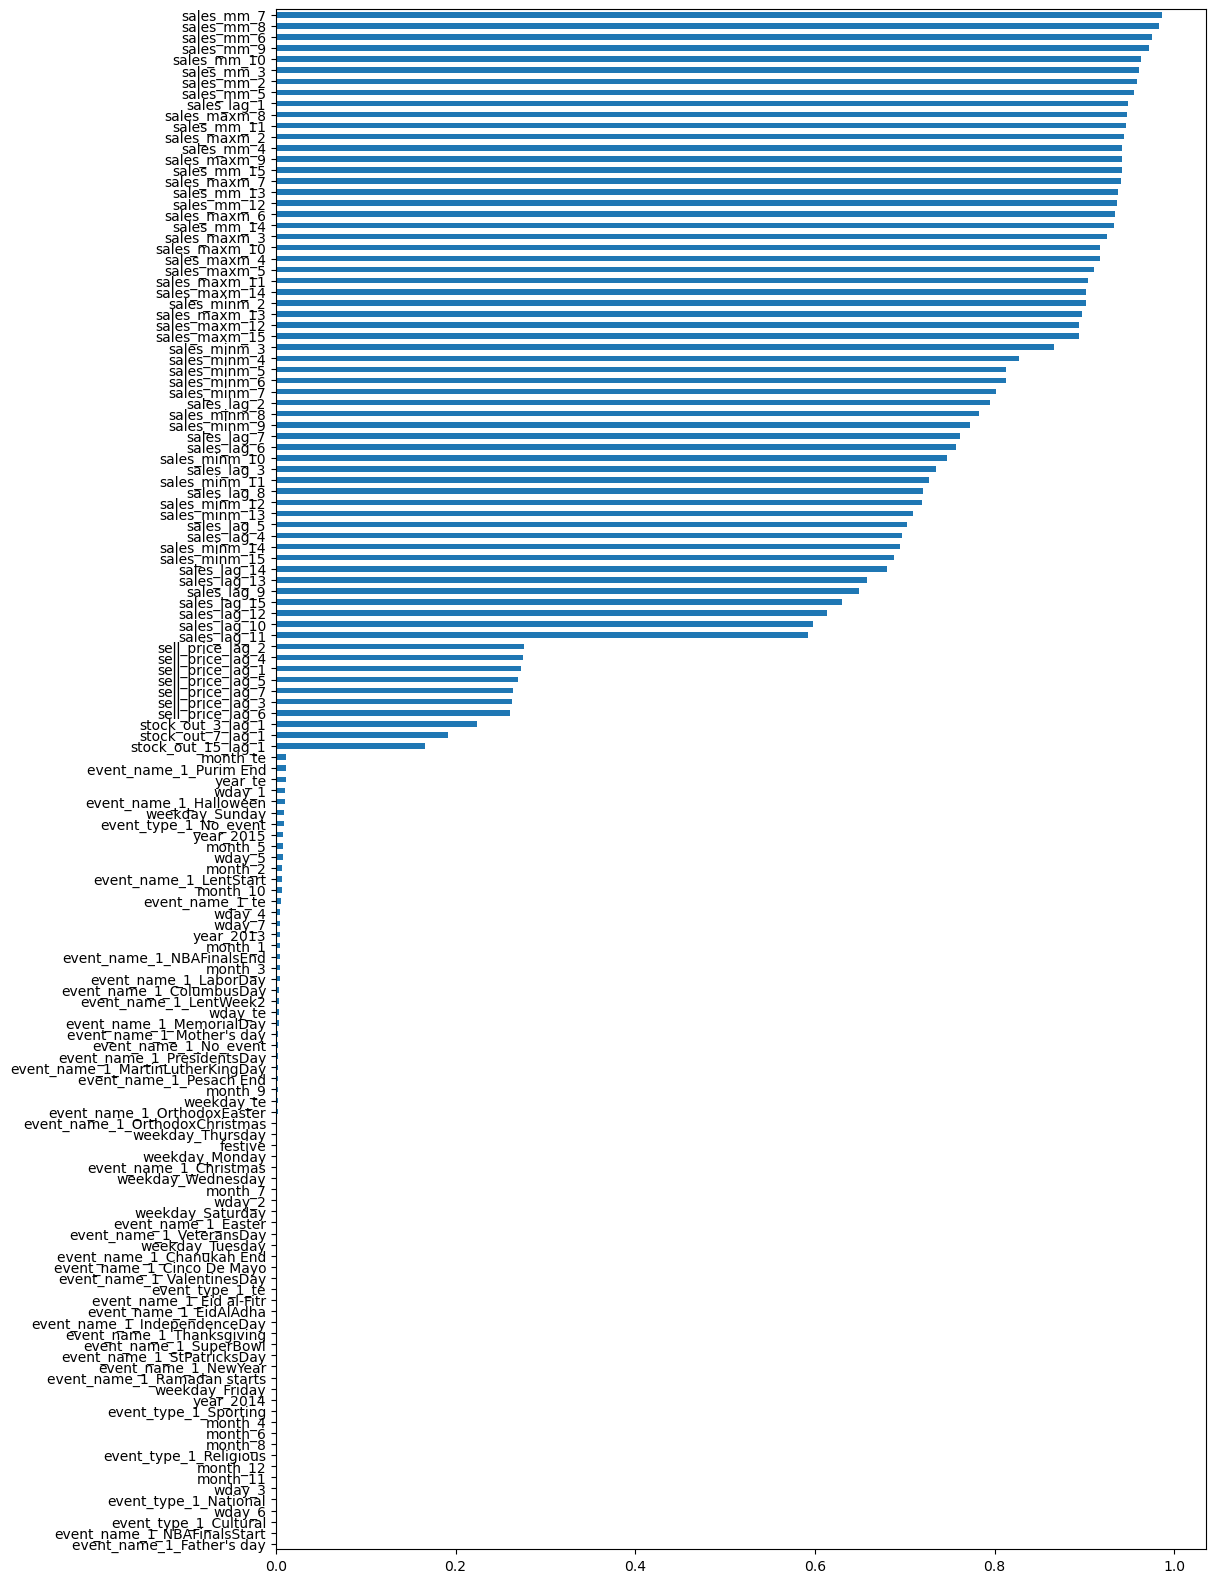

In [38]:
g = rank_mi.importance_mi.sort_values().plot.barh(figsize=(12,20))
g.set_yticklabels(rank_mi.sort_values(by='importance_mi').variable)
plt.show()

#### Select variables

See the position of the variable year_2013

In [39]:
rank_mi.reset_index().iloc[60:100]

index                          variable  importance_mi  ranking_mi
60     76                  sell_price_lag_5       0.268951          60
61     78                  sell_price_lag_7       0.263561          61
62     74                  sell_price_lag_3       0.262301          62
63     77                  sell_price_lag_6       0.260100          63
64     79                 stock_out_3_lag_1       0.223274          64
65     80                 stock_out_7_lag_1       0.191853          65
66     81                stock_out_15_lag_1       0.165506          66
67     66                          month_te       0.011479          67
68     53            event_name_1_Purim End       0.011332          68
69     65                           year_te       0.010717          69
70     15                            wday_1       0.010098          70
71     37            event_name_1_Halloween       0.009595          71
72     25                    weekday_Sunday       0.009259          72
73     62             event_type_1_No_event       0.008897          73
74      2                         year_2015       0.007624          74
75      7                           month_5       0.007351          75
76     19                            wday_5       0.007328          76
77      4                           month_2       0.007005          77
78     40            event_name_1_LentStart       0.006684          78
79     12                          month_10       0.006575          79
80     69                   event_name_1_te       0.005651          80
81     18                            wday_4       0.004522          81
82     21                            wday_7       0.004436          82
83      0                         year_2013       0.004379          83
84      3                           month_1       0.004218          84
85     45         event_name_1_NBAFinalsEnd       0.004206          85
86      5                           month_3       0.004085          86
87     39             event_name_1_LaborDay       0.004028          87
88     32          event_name_1_ColumbusDay       0.003842          88
89     41            event_name_1_LentWeek2       0.003521          89
90     67                           wday_te       0.003337          90
91     43          event_name_1_MemorialDay       0.003102          91
92     44         event_name_1_Mother's day       0.002801          92
93     48             event_name_1_No_event       0.002744          93
94     52        event_name_1_PresidentsDay       0.002349          94
95     42  event_name_1_MartinLutherKingDay       0.002342          95
96     51           event_name_1_Pesach End       0.002120          96
97     11                           month_9       0.001979          97
98     68                        weekday_te       0.001973          98
99     50       event_name_1_OrthodoxEaster       0.001959          99

In [40]:
selected_vars =  rank_mi.iloc[:80].variable

Generate dataframe with the selected variables

In [41]:
x_mi = x[selected_vars].copy()

Include segmentation variables

In [42]:
x_selected = pd.concat([df[['date', 'store_id', 'item_id']], x_mi], axis=1)

### Save training dataset

Save dataset of selected predictor variables and target

In [43]:
x_selected.to_pickle('../data/x_selected_vars.pickle')
y.to_pickle('../data/y_selected_var.pickle')

Save final variables

In [44]:
x_selected.iloc[0].to_pickle('../data/final_vars.pickle')